In [1]:
import os

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

# load required packages
library(DESeq2)
library(sva) 
library(tidyverse)
library(RColorBrewer)
library(ComplexHeatmap) 
library(DEGreport) 
library(tximport) 
library(ggplot2)
library(ggrepel)
library(biomaRt)
library(stringr)
library(readxl)
library(ggpubr) 
library(viridis)
library(rtracklayer)
library(limma)
library(forcats)



R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to console]: The following objects are masked from ‘package:base’:

    expand.grid, I, unname


R[write to console]: Loading r

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks nlme::collapse(), IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::slice()      masks IRanges::slice()
✖ readr::spec()       masks genefilter::

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: 
Attaching package: ‘ComplexHeatmap’


R[write to console]: The following object is masked from ‘package:genefilter’:

    dist2


R[write to console]: Loading required package: viridisLite

R[write to console]: 
Attaching package: ‘l

In [4]:
%%R

# read in RNA-seq sample metadata file (RNA-seq data from Hasel et al 2021, PMID: PMID: 34413515, GEO accession GSE165069)
samples <- read.table("relative_file_path/input_data/SraRunTable.txt", header = TRUE, sep = ",")

In [5]:
%%R

samples

           Run Assay.Type AvgSpotLen      Bases  BioProject    BioSample
1  SRR13481737    RNA-Seq        102 2396829252 PRJNA693181 SAMN17379493
2  SRR13481738    RNA-Seq        102 2393927250 PRJNA693181 SAMN17379493
3  SRR13481739    RNA-Seq        102 2458293840 PRJNA693181 SAMN17379492
4  SRR13481740    RNA-Seq        102 2456726610 PRJNA693181 SAMN17379492
5  SRR13481741    RNA-Seq        102 2091136272 PRJNA693181 SAMN17379491
6  SRR13481742    RNA-Seq        102 2088413586 PRJNA693181 SAMN17379491
7  SRR13481767    RNA-Seq        102 2711394396 PRJNA693181 SAMN17379514
8  SRR13481768    RNA-Seq        102 2719354170 PRJNA693181 SAMN17379514
9  SRR13481769    RNA-Seq        102 3277529994 PRJNA693181 SAMN17379513
10 SRR13481770    RNA-Seq        102 3288234996 PRJNA693181 SAMN17379513
11 SRR13481771    RNA-Seq        102 2368638696 PRJNA693181 SAMN17379512
12 SRR13481772    RNA-Seq        102 2372169222 PRJNA693181 SAMN17379512
        Bytes              Cell_type Center.Name Co

In [6]:
%%R
# create and name salmon transcript counts file paths (file tree structure is "relative_file_path/input_data/[Sample]/quant.sf", with subfolders for each samples)
files <- file.path("relative_file_path/input_data/hasel_2021_tici/salmon/output", samples$Run, "quant.sf")
names(files) <- samples$Run

In [7]:
%%R
# read in Ensembl rat genome GTF file (obtained from https://ftp.ensembl.org/pub/release-108/gtf/rattus_norvegicus/Rattus_norvegicus.mRatBN7.2.108.gtf.gz)
rat.gtf.df <- as.data.frame(import('relative_file_path/input_data/Rattus_norvegicus.mRatBN7.2.108.gtf'))

# create transcript-to-gene data frame
tx2gene <- rat.gtf.df[,c("transcript_id", "gene_name")]

In [8]:
%%R
# drop rows of transcript-to-gene data frame which contain an NA value for either column
tx2gene <- tx2gene %>% drop_na(gene_name) %>% drop_na(transcript_id)

In [9]:
%%R

head(tx2gene, n = 25)

        transcript_id gene_name
1  ENSRNOT00000087667     Olr56
2  ENSRNOT00000087667     Olr56
3  ENSRNOT00000087667     Olr56
4  ENSRNOT00000087667     Olr56
5  ENSRNOT00000087667     Olr56
6  ENSRNOT00000119508      Irgq
7  ENSRNOT00000119508      Irgq
8  ENSRNOT00000119508      Irgq
9  ENSRNOT00000119508      Irgq
10 ENSRNOT00000119508      Irgq
11 ENSRNOT00000119508      Irgq
12 ENSRNOT00000119508      Irgq
13 ENSRNOT00000119508      Irgq
14 ENSRNOT00000119508      Irgq
15 ENSRNOT00000119508      Irgq
16 ENSRNOT00000119508      Irgq
17 ENSRNOT00000024353     Doc2g
18 ENSRNOT00000024353     Doc2g
19 ENSRNOT00000024353     Doc2g
20 ENSRNOT00000024353     Doc2g
21 ENSRNOT00000024353     Doc2g
22 ENSRNOT00000024353     Doc2g
23 ENSRNOT00000024353     Doc2g
24 ENSRNOT00000024353     Doc2g
25 ENSRNOT00000024353     Doc2g


In [10]:
%%R

# import salmon counts files
txi <- tximport(files, type="salmon", txIn = TRUE, txOut = FALSE, tx2gene=tx2gene, importer=read_tsv, ignoreTxVersion=TRUE)

R[write to console]: 1 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 2 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 3 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 4 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 5 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 6 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 7 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 8 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 9 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 10 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 11 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 12 


Rows: 46726 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


R[write to console]: 

R[write to console]: removing duplicated transcript rows from tx2gene

R[write to console]: transcripts missing from tx2gene: 5496

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



In [11]:
%%R
# rename interferon treated condition metadata to 'TICI'
samples <- samples %>% mutate(stimulation = ifelse(stimulation == "IFNb (1000 U/ml)+TIC", "TICI", "PBS"))

In [12]:
%%R
# create DESeq dataset object
ddsTxi <- DESeqDataSetFromTximport(txi,
                                   colData = samples,
                                   design = ~stimulation)

R[write to console]: using counts and average transcript lengths from tximport



In [13]:
%%R
# collapse replicates into individual samples
dds <- collapseReplicates(ddsTxi, groupby = ddsTxi$BioSample, ddsTxi$Run)

In [14]:
%%R
# estimate size factors, retrieve normalized counts, and filter out genes for which normalized counts are not greater than or equal to 5 in at least two samples
dds <- estimateSizeFactors(dds)
nc <- counts(dds, normalized=TRUE)
filter <- rowSums(nc >= 5) >= 2
ddssva <- dds[filter,]

ddssva <- dds

# create model matrices for sva
dat  <- counts(ddssva, normalized = TRUE)
idx  <- rowMeans(dat) > 1
dat  <- dat[idx, ]
mod  <- model.matrix(~stimulation, colData(ddssva))
mod0 <- model.matrix(~ 1, colData(ddssva))

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size



In [15]:
%%R
# run sva
set.seed(111)
svseq <- svaseq(dat, mod, mod0)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [16]:
%%R
# add surrogate variables to DESeq2 design
ddssva$SV1 <- svseq$sv[,1]
ddssva$SV2 <- svseq$sv[,2]
design(ddssva) <- ~ SV1 + SV2 + stimulation

In [17]:
%%R
# estimate size factors, dispersions, and run negative bionmial Wald Test
ddssva <- estimateSizeFactors(ddssva)
ddssva <- estimateDispersions(ddssva)
ddssva <- nbinomWaldTest(ddssva, maxit = 1000)

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



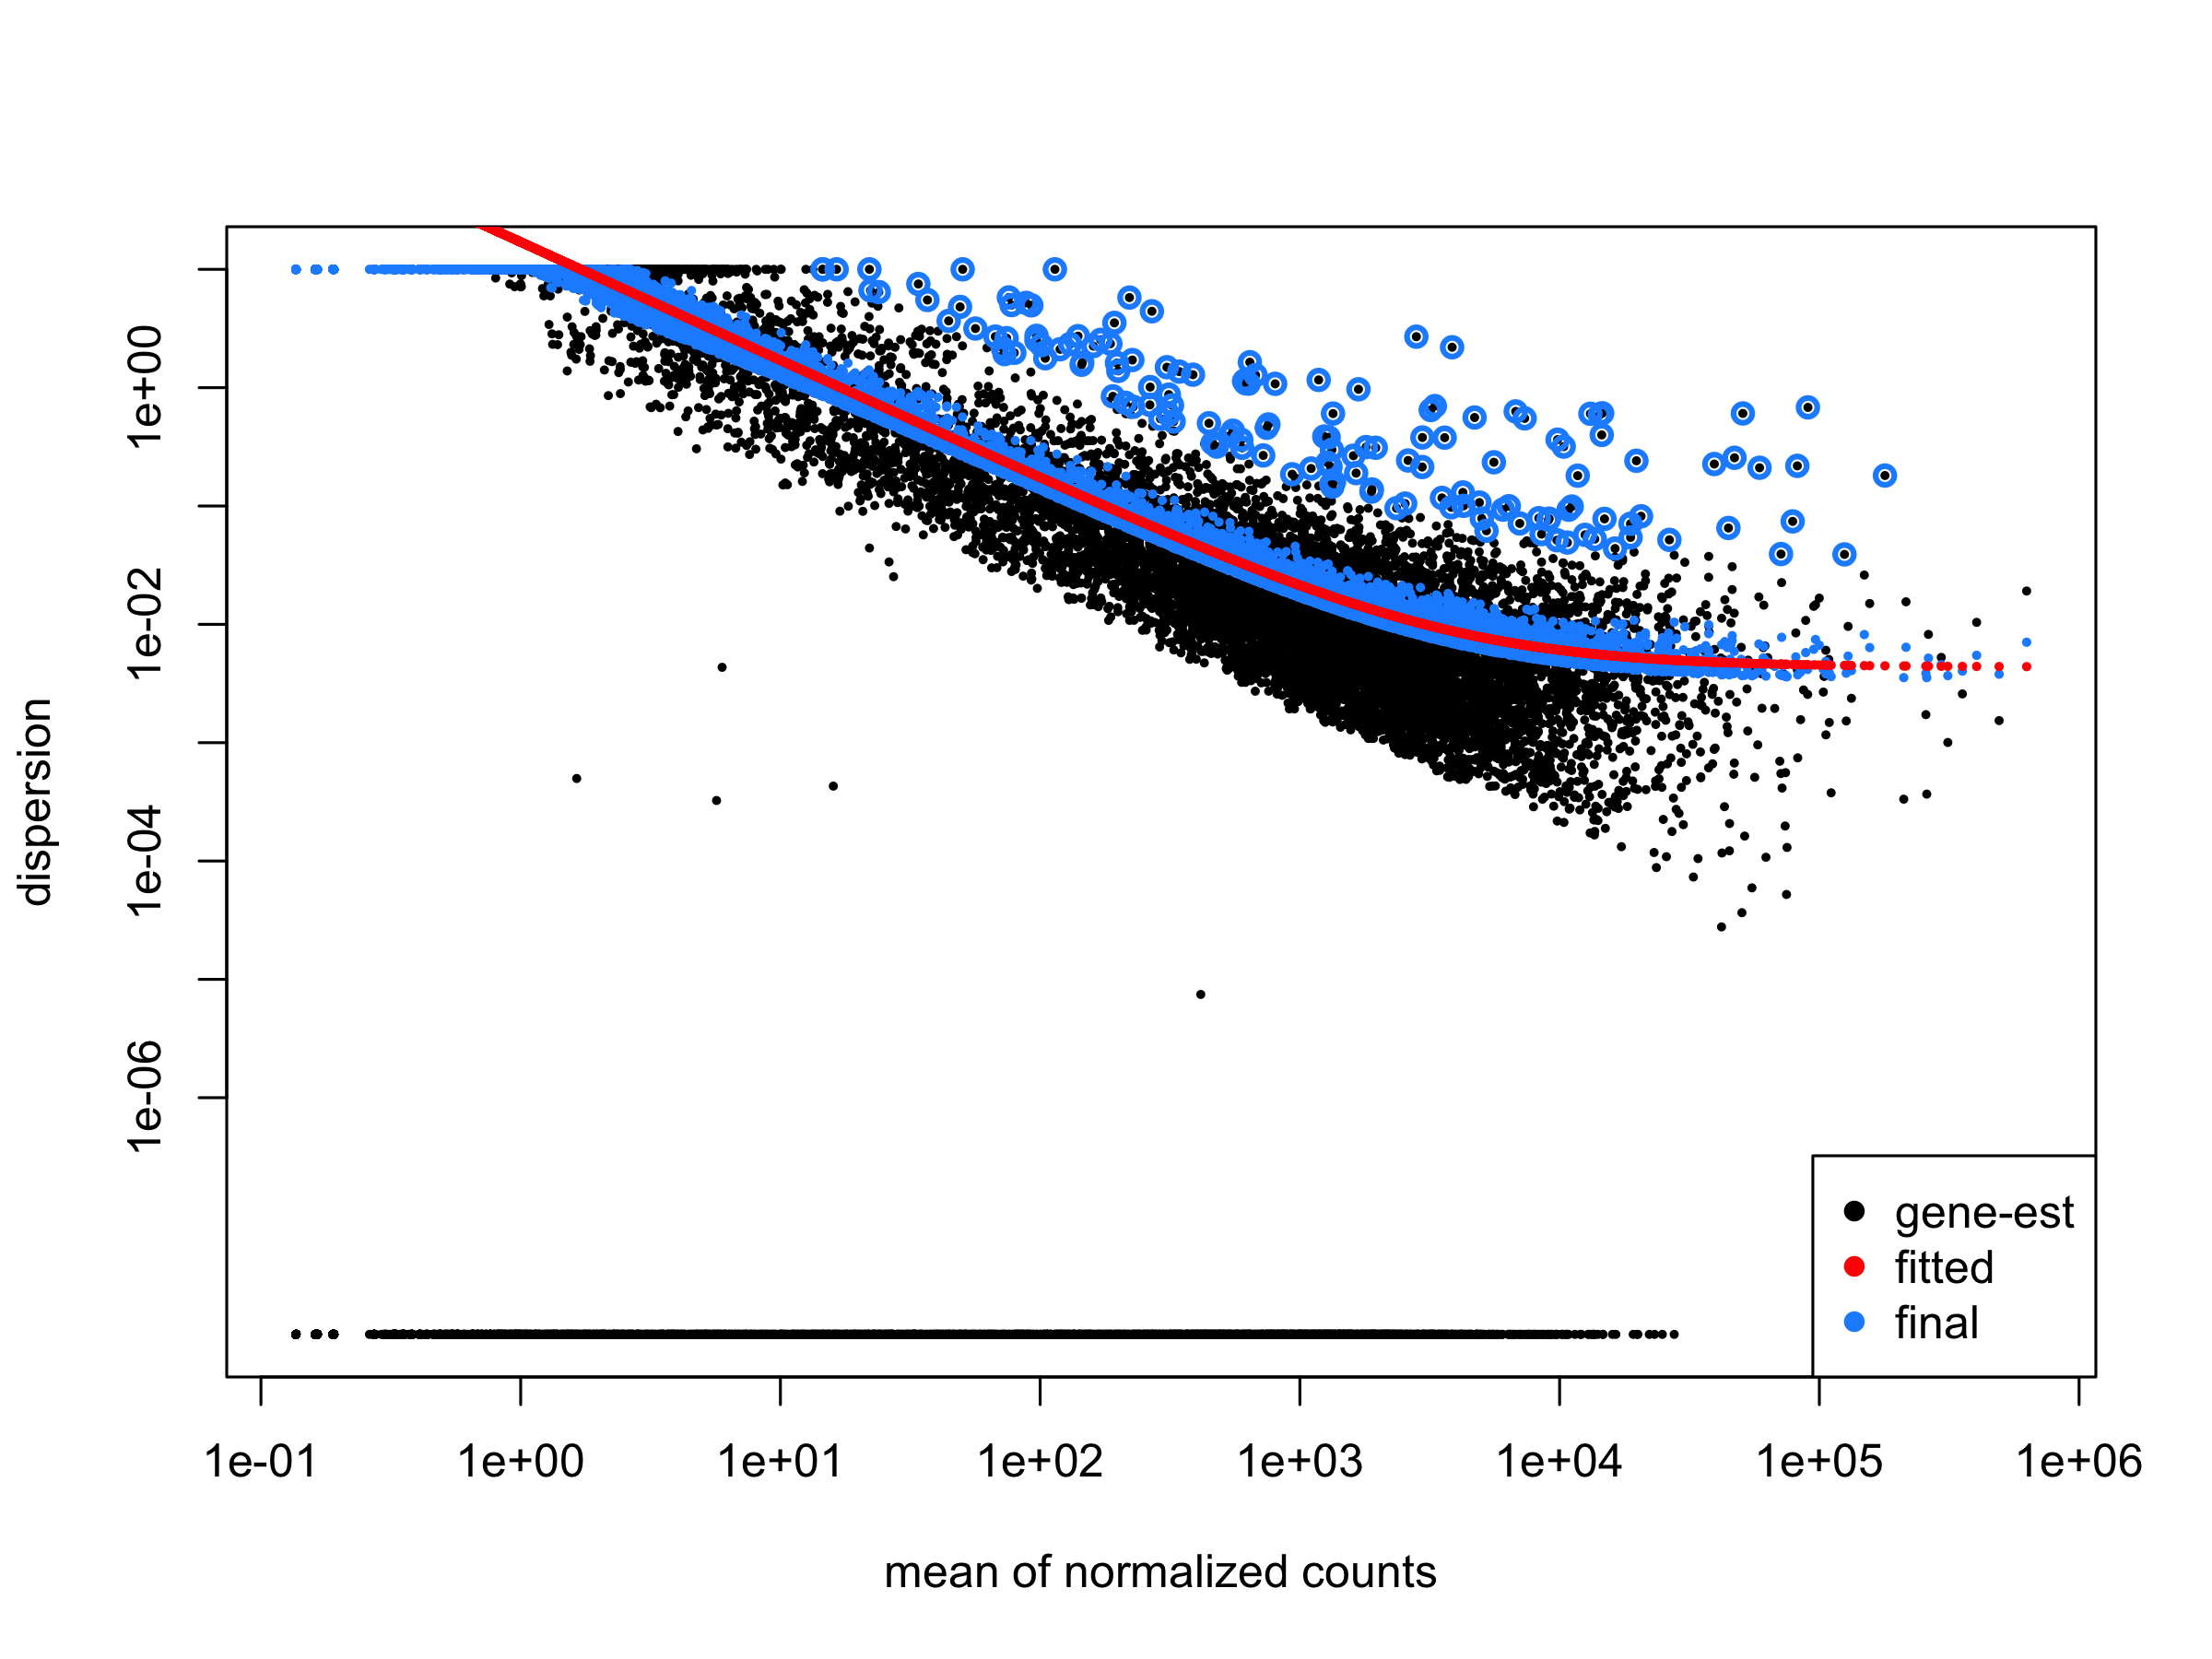

In [18]:
%%R -w 8 -h 6 --units in -r 300
# plot dispersion estimates
plotDispEsts(ddssva)

In [19]:
%%R
# obtain rlog data
rld <- rlog(ddssva, blind=FALSE)

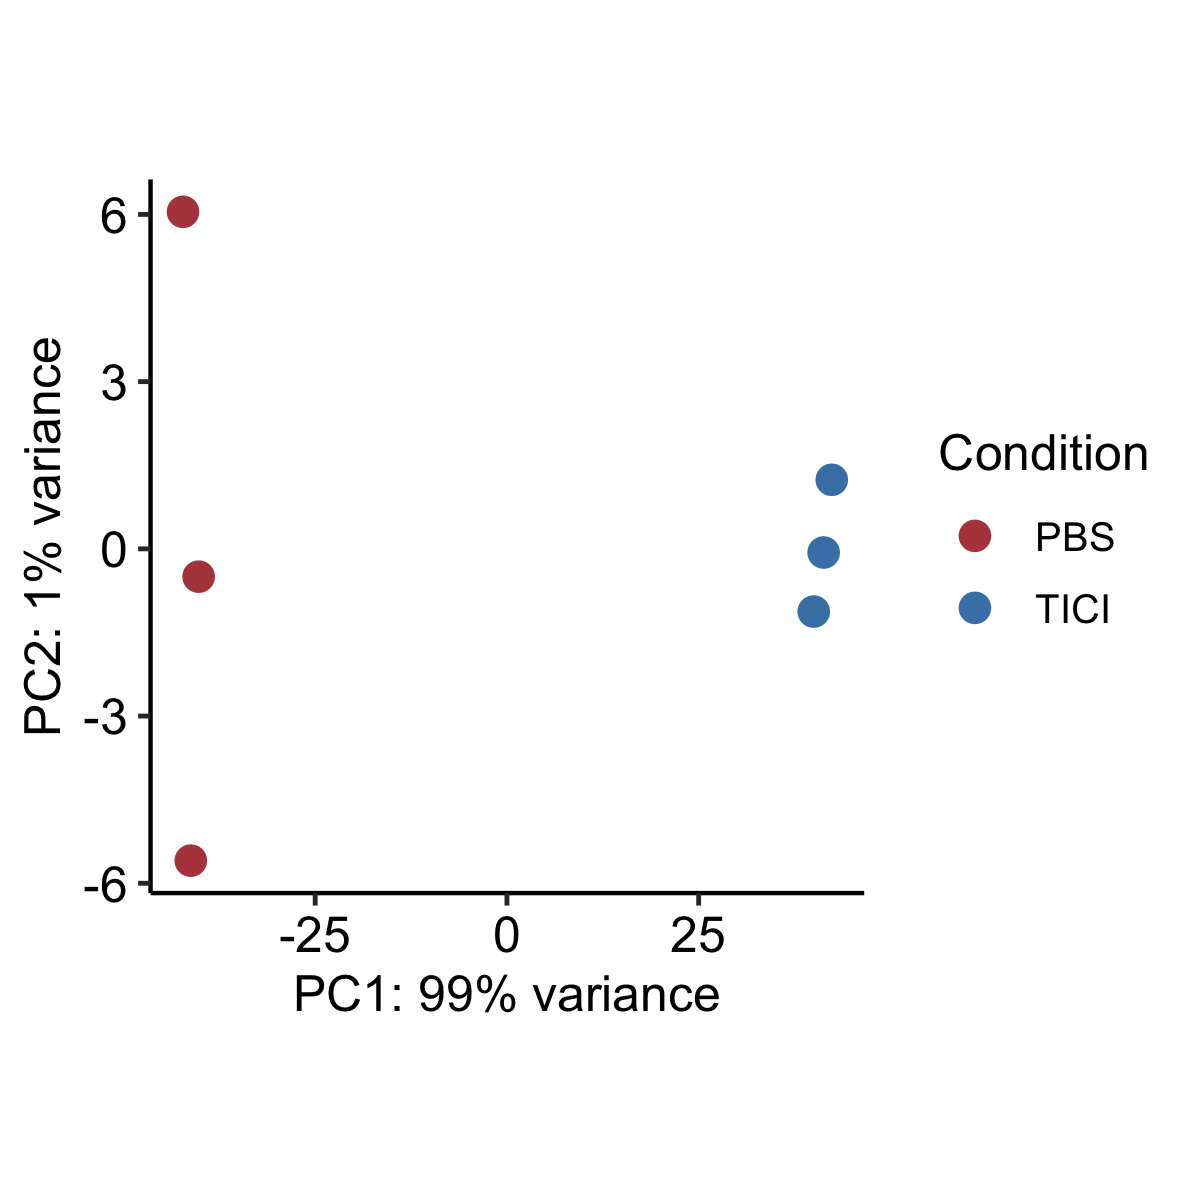

In [20]:
%%R -w 4 -h 4 --units in -r 300
# extract PCA results from plotPCA deseq2 function 
pcaplot <- plotPCA(rld, intgroup=c("stimulation"))  
pca.data <- plotPCA(rld, intgroup=c("stimulation"), returnData = TRUE)  

# create PCA plot
ggplot(pca.data,aes(x=PC1,y=PC2,color=stimulation)) + 
  geom_point(size = 3) + 
  scale_color_manual(values = c("#B4464B", "#4682B4")) +
  theme_pubr() + 
  theme(aspect.ratio = 1, legend.position = "right") + 
  labs(color = "Condition", x = pcaplot$labels$x, y = pcaplot$labels$y) 

In [21]:
%%R
# get LFC shurnken results contrasting TICI versus PBS treated astrocytes
TICI.v.PBS.sva <- lfcShrink(ddssva, coef="stimulation_TICI_vs_PBS", type="apeglm")
sig.TICI.v.PBS.sva <- TICI.v.PBS.sva %>% data.frame() %>% filter(abs(log2FoldChange) > 0.25) %>% filter(padj < 0.05) %>% arrange(desc(log2FoldChange), desc(baseMean))
sig.TICI.v.PBS.sva$gene <- rownames(sig.TICI.v.PBS.sva)

R[write to console]: using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [22]:
%%R

head(sig.TICI.v.PBS.sva %>% arrange(padj))

                baseMean log2FoldChange     lfcSE pvalue padj           gene
Rsad2          67320.308       7.936406 0.1163475      0    0          Rsad2
Slfn2          10209.780       7.735843 0.1532510      0    0          Slfn2
Cfb            33429.617       7.687211 0.1292878      0    0            Cfb
AABR07058464.1  5086.639       7.290653 0.1743729      0    0 AABR07058464.1
Oas1k          10500.270       7.213177 0.1415744      0    0          Oas1k
Serpine1        9592.515       7.071410 0.1559852      0    0       Serpine1


In [23]:
%%R
# read in MaxQuant proteomics results file
prot.df <- read_excel("relative_file_path/input_data/Rodent_TICI_VEH_CellularProteome_Mouse_Rat_imputed.xls")

New names:
• `TICI` -> `TICI...16`
• `VEH` -> `VEH...17`
• `TICI` -> `TICI...18`
• `VEH` -> `VEH...19`
• `TICI` -> `TICI...20`
• `VEH` -> `VEH...21`
• `TICI` -> `TICI...22`
• `VEH` -> `VEH...23`
• `TICI` -> `TICI...24`
• `VEH` -> `VEH...25`


In [24]:
%%R

prot.df

# A tibble: 2,335 × 25
   Significant minus l…¹ p val…² Diffe…³ TICI/…⁴ Prote…⁵ Prote…⁶ Gene …⁷ Pepti…⁸
   <chr>           <dbl>   <dbl>   <dbl>   <dbl> <chr>   <chr>   <chr>   <chr>  
 1 +                7.24 5.80e-8    2.26    4.79 Q3U5Q7  UMP-CM… Cmpk2   5      
 2 +                6.60 2.51e-7    1.60    3.04 Q05961  2-5-ol… Oas1a   4      
 3 +                6.54 2.87e-7    2.28    4.86 Q64345  Interf… Ifit3   2      
 4 +                6.42 3.82e-7    1.43    2.70 Q8CFB4  Guanyl… Gbp5    1      
 5 +                5.86 1.39e-6    2.46    5.51 Q64112  Interf… Ifit2   2      
 6 +                5.85 1.43e-6    1.45    2.73 P07151  Beta-2… B2m     4      
 7 +                5.48 3.27e-6    2.05    4.13 P18588  Interf… Mx1     37     
 8 +                5.48 3.28e-6    1.02    2.02 Q6AYC2  Immuni… Irgm    3      
 9 +                5.36 4.35e-6    1.68    3.20 Q63663  Interf… Gbp2    24     
10 +                5.27 5.32e-6    1.13    2.19 Q63184  Interf… Eif2ak2 4      
# … w

In [25]:
%%R

colnames(prot.df)

 [1] "Significant"           "minus log(p)"          "p value"              
 [4] "Difference"            "TICI/VEH"              "Protein IDs"          
 [7] "Protein names"         "Gene names"            "Peptides"             
[10] "Sequence coverage [%]" "Mol. weight [kDa]"     "Q-value"              
[13] "Score"                 "Intensity"             "MS/MS count"          
[16] "TICI...16"             "VEH...17"              "TICI...18"            
[19] "VEH...19"              "TICI...20"             "VEH...21"             
[22] "TICI...22"             "VEH...23"              "TICI...24"            
[25] "VEH...25"             


In [26]:
%%R
# remove unneeded columns
prot.df <- prot.df[, c("p value", "Difference", "Protein IDs", "Protein names", "Gene names", "TICI...16", "VEH...17", "TICI...18", "TICI...20", "VEH...21", "TICI...22", "VEH...23", "TICI...24", "VEH...25")]

In [27]:
%%R
# rename columns
colnames(prot.df) <- c("pval", "log2FC", "protein", "protein_names", "gene_names", "TICI_1", "VEH_1", "TICI_2", "TICI_3", "VEH_3", "TICI_4", "VEH_4", "TICI_5", "VEH_5")

In [28]:
%%R
# get number of proteins for which multiple corresponding genes are named
length(grep(";", prot.df$gene_names)) # 97 protein entries have multiple gene names listed

[1] 97


In [29]:
%%R
# list all gene entries for proteins with multiple corresponding genes
prot.df[grep(";", prot.df$gene_names),]$gene_names

 [1] "Mx2;Mx3"                                                                                  
 [2] "H2-D1;H2-K1"                                                                              
 [3] "H2-Q10;H2-Q8;H2-Q7;H2-D1;H2-Q9;H2-K1"                                                     
 [4] "H2-D1;H2-K1;H2-L"                                                                         
 [5] "Ybx1;Ybx2"                                                                                
 [6] "Uchl3;Uchl4"                                                                              
 [7] "Gsta3;Gsta5"                                                                              
 [8] "Jak1;Jak2"                                                                                
 [9] "Sumo2;Sumo3"                                                                              
[10] "Hras;Kras;Nras"                                                                           
[11] "Nras;Hras;Kras"         

In [30]:
%%R
# extract all protein entires with multiple genes
mult.gene.df <- prot.df[grep(";", prot.df$gene_names),]

mult.gene.df

# A tibble: 97 × 14
        pval log2FC protein     prote…¹ gene_…² TICI_1 VEH_1 TICI_2 TICI_3 VEH_3
       <dbl>  <dbl> <chr>       <chr>   <chr>    <dbl> <dbl>  <dbl>  <dbl> <dbl>
 1 0.0000522  1.83  P18589;P18… Interf… Mx2;Mx3   20.6  18.5   20.1   20.4  18.4
 2 0.00126    1.42  P14426;P04… H-2 cl… H2-D1;…   17.2  16.1   16.3   17.4  15.3
 3 0.00379    1.07  P01898;P14… H-2 cl… H2-Q10…   15.3  14.3   15.8   15.6  14.5
 4 0.00483    1.49  P01900;P01… H-2 cl… H2-D1;…   14.0  12.6   13.4   13.1  11.3
 5 0.0949     0.202 P62960;Q9Z… Nuclea… Ybx1;Y…   17.9  17.4   17.7   17.6  17.6
 6 0.0974    -0.156 Q9JKB1;P58… Ubiqui… Uchl3;…   17.0  17.0   16.7   16.8  17.0
 7 0.107     -0.212 P04904;P46… Glutat… Gsta3;…   17.8  18.1   17.6   17.5  17.6
 8 0.110      0.199 P52332;Q62… Tyrosi… Jak1;J…   14.6  14.4   14.6   14.5  14.4
 9 0.118     -0.170 P61959;Q5X… Small … Sumo2;…   15.1  15.1   14.8   15.1  15.2
10 0.130     -0.161 Q61411;P32… GTPase… Hras;K…   17.0  17.3   16.9   17.1  17.2
# … with

In [31]:
%%R
# split the gene entries with multiple genes listed into separate rows
prot.df <- prot.df %>% 
    mutate(gene_names = strsplit(as.character(gene_names), ";")) %>% 
    unnest(gene_names)

In [32]:
%%R
# make new data frame containing only proteins for which the corresponding gene entries are also present in the DESeq2 results object
conserved.prots <- prot.df[(prot.df$gene_names %in% rownames(TICI.v.PBS.sva)),]

In [33]:
%%R
# rename columns
conserved.prots <- conserved.prots[,c("protein", "gene_names", "log2FC", "pval", "TICI_1", "VEH_1", "TICI_2", "TICI_3", "VEH_3", "TICI_4", "VEH_4", "TICI_5", "VEH_5")]

In [34]:
%%R

conserved.prots

# A tibble: 2,183 × 13
   protein gene_n…¹ log2FC    pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
   <chr>   <chr>     <dbl>   <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 Q3U5Q7  Cmpk2      2.26 5.80e-8   17.7  15.6   17.8   18.1  15.5   17.8  15.4
 2 Q05961  Oas1a      1.60 2.51e-7   17.0  15.4   16.9   17.0  15.3   17.0  15.2
 3 Q64345  Ifit3      2.28 2.87e-7   17.3  15.0   17.1   17.5  14.9   17.1  14.7
 4 Q8CFB4  Gbp5       1.43 3.82e-7   15.6  14.0   15.5   15.5  14.1   15.4  13.9
 5 Q64112  Ifit2      2.46 1.39e-6   16.4  13.7   15.9   16.6  13.8   15.9  13.6
 6 P07151  B2m        1.45 1.43e-6   18.5  17.1   18.3   18.4  17.0   18.6  16.8
 7 P18588  Mx1        2.05 3.27e-6   21.3  19.1   20.8   21.1  18.9   20.7  18.7
 8 Q6AYC2  Irgm       1.02 3.28e-6   17.0  16.1   16.8   16.9  15.9   16.9  15.7
 9 Q63663  Gbp2       1.68 4.35e-6   19.8  18.7   20.0   20.2  18.3   20.3  18.2
10 Q63184  Eif2ak2    1.13 5.32e-6   16.8  15.7   16.9   16.8  15.9   16.9  15.6
# … w

In [35]:
%%R
# subset DESeq2 results object to only contain genes for which corresponding proteins are present in the MaxQuant results dataframe
conserved.genes <- TICI.v.PBS.sva[(rownames(TICI.v.PBS.sva) %in% conserved.prots$gene_names), c("log2FoldChange", "padj")]
conserved.genes$gene <- rownames(conserved.genes)

In [36]:
%%R
# create a merged data frame combining the proteomics and DESeq2 results dataframes, merging by gene name
merge.df <- merge(x = conserved.prots, y = as.data.frame(conserved.genes), by.x = "gene_names", by.y = "gene", all.x = TRUE)

In [37]:
%%R

head(merge.df)

  gene_names protein      log2FC      pval   TICI_1    VEH_1   TICI_2   TICI_3
1        A2m  P06238 -0.55609059 0.0242572 12.14574 12.49566 11.64970 12.23721
2     Aarsd1  Q5XI97 -0.12239695 0.5743791 16.09573 16.32766 15.38083 15.97067
3   Aasdhppt  B2RYJ4 -0.12168908 0.3611164 13.29203 13.40554 12.90384 13.26021
4       Abat  P50554 -0.05338068 0.7157455 18.49985 18.52936 18.67855 18.85924
5      Abcb7  Q704E8 -0.12706885 0.3159785 13.49673 13.29203 12.91193 13.30549
6      Abcd3  P16970 -0.01899767 0.9181420 17.44484 17.38119 17.82240 17.73165
     VEH_3   TICI_4    VEH_4   TICI_5    VEH_5 log2FoldChange         padj
1 12.65754 11.49720 12.19165 12.14561 12.61988     1.01962779 8.693549e-05
2 15.78405 15.52903 15.55540 15.79073 15.83607     0.06827449 8.464256e-01
3 13.16414 13.04941 13.08899 13.32249 13.49047     0.04554746 8.900199e-01
4 18.94752 18.86124 18.90674 19.04924 18.98840    -0.61518845 2.438979e-02
5 13.51188 13.21649 13.27727 13.27958 13.39527    -0.46091600 1.915666e-

In [38]:
%%R
# add a significance column describing whether each entry is statistically differentially expressed/abundant at the RNA and/or protein level
merge.df <- merge.df %>% mutate(significance = ifelse((pval < 0.05) & (padj < 0.05), "Both", 
                                                     ifelse((pval < 0.05) & (padj >= 0.05), "Protein only", 
                                                           ifelse((pval >= 0.05) & (padj < 0.05), "RNA only", 
                                                                 ifelse((pval >= 0.05) & (padj >= 0.05), "Neither", "X")))))

In [39]:
%%R
# remove entries for which the DESeq2 results object contained an NA entry in the log2FC or p-value columns
merge.df <- merge.df %>% filter(!is.na(log2FoldChange) & !is.na(padj))

In [40]:
%%R
# summarise the number of entries in each significance category
table(merge.df$significance)


        Both      Neither Protein only     RNA only 
          75         1099           14          966 


In [41]:
%%R
# re-order significance entries
merge.df$significance <- factor(merge.df$significance, levels = c("Neither", "RNA only", "Protein only", "Both"))

In [42]:
%%R

merge.df$Significance <- as.character(merge.df$significance)

In [43]:
%%R
# alter significance category Both to reflect the agreement of sign of the significance (positive or negative) at the protein level and gene expression level
merge.df <- merge.df %>% mutate(Significance = ifelse((Significance == "Both") & (sign(log2FoldChange) == sign(log2FC)), "Both (concordant)",
                                         ifelse((Significance == "Both") & (sign(log2FoldChange) != sign(log2FC)), "Both (discordant)", Significance)))

In [44]:
%%R
# summarise the number protein-gene pairs of each category
table(merge.df$Significance)


Both (concordant) Both (discordant)           Neither      Protein only 
               67                 8              1099                14 
         RNA only 
              966 


In [45]:
%%R
# re-level factors
merge.df$Significance <- factor(merge.df$Significance, levels = c("Neither", "RNA only", "Protein only", "Both (discordant)", "Both (concordant)"))

In [46]:
%%R
# rename categories to reflect their number of entries (for plotting)
merge.df <- merge.df %>% mutate(Significance = ifelse(Significance == "Both (concordant)", "Both (concordant)(n = 67)", 
                                                      ifelse(Significance == "Both (discordant)", "Both (discordant)(n = 8)",
                                                             ifelse(Significance == "Protein only", "Protein only (n = 14)",
                                                                    ifelse(Significance == "RNA only", "RNA only (n = 966)",
                                                                        ifelse(Significance == "Neither", "Neither (n = 1099)", Significance))))))

In [47]:
%%R
# re-level entries
merge.df$Significance <- factor(merge.df$Significance, levels = c("Neither (n = 1099)", "RNA only (n = 966)", "Protein only (n = 14)", "Both (discordant)(n = 8)", "Both (concordant)(n = 67)"))

In [48]:
%%R
# obtain TPM matrix from tximport object
tpm.mat <- txi$abundance

In [49]:
%%R

head(tpm.mat)

              SRR13481737 SRR13481738 SRR13481739 SRR13481740 SRR13481741
1700066B19Rik    0.000000    0.000000    0.000000    0.000000    0.000000
1700092M07Rik    0.324039    0.783459    0.127595    0.510089    1.717435
3110082J24Rik    7.954385    4.429773    3.572939    4.883415    5.780946
4930444P10Rik    0.000000    0.000000    0.000000    0.000000    0.000000
4933400A11Rik    0.000000    0.000000    0.000000    0.000000    0.000000
4933403O08Rik    0.000000    0.000000    0.000000    0.000000    0.000000
              SRR13481742 SRR13481767 SRR13481768 SRR13481769 SRR13481770
1700066B19Rik    0.000000    0.000000           0    0.429766    0.000000
1700092M07Rik    0.581518    0.135223           0    0.000000    0.290450
3110082J24Rik    3.831189    0.391192           0    0.000000    0.320858
4930444P10Rik    0.000000    0.000000           0    0.000000    0.000000
4933400A11Rik    0.000000    0.000000           0    0.000000    0.000000
4933403O08Rik    0.000000    0.000000 

In [50]:
%%R
# combine technical replicate columns to reflect single samples
tpm.mat <- data.frame("PBS_1" = rowSums(tpm.mat[, c(1, 2)]), 
                     "PBS_2" = rowSums(tpm.mat[, c(3, 4)]), 
                     "PBS_3" = rowSums(tpm.mat[, c(5, 6)]), 
                     "TICI_1" = rowSums(tpm.mat[, c(7, 8)]), 
                     "TICI_2" = rowSums(tpm.mat[, c(9, 10)]), 
                     "TICI_3" = rowSums(tpm.mat[, c(11, 12)]))

In [51]:
%%R
# divide each value by 2 to correct for combining columns
tpm.mat <- tpm.mat/2

In [52]:
%%R
# obtain average TPM expression for the PBS and TICI treated cultures for each gene
avg.tpm.pbs <- rowMeans(tpm.mat[,1:3])
avg.tpm.tici <- rowMeans(tpm.mat[,4:6])

In [53]:
%%R
# filter out only the genes present in the merged dataframe object
avg.tpm.pbs <- avg.tpm.pbs[names(avg.tpm.pbs) %in% merge.df$gene]
avg.tpm.tici <- avg.tpm.tici[names(avg.tpm.tici) %in% merge.df$gene]

In [54]:
%%R
# create new blank column in merged data frame which will be filled in with the average PBS and TICI TPM values for each gene 
merge.df$pbs_tpm <- NA
merge.df$tici_tpm <- NA

In [55]:
%%R
# add averate TPM value for each gene in merged data frame
for(i in 1:nrow(merge.df)){
    merge.df[i, ]$pbs_tpm <- avg.tpm.pbs[merge.df[i, ]$gene]
    merge.df[i, ]$tici_tpm <- avg.tpm.tici[merge.df[i, ]$gene]
}

In [56]:
%%R

head(merge.df)

  gene_names protein      log2FC      pval   TICI_1    VEH_1   TICI_2   TICI_3
1        A2m  P06238 -0.55609059 0.0242572 12.14574 12.49566 11.64970 12.23721
2     Aarsd1  Q5XI97 -0.12239695 0.5743791 16.09573 16.32766 15.38083 15.97067
3   Aasdhppt  B2RYJ4 -0.12168908 0.3611164 13.29203 13.40554 12.90384 13.26021
4       Abat  P50554 -0.05338068 0.7157455 18.49985 18.52936 18.67855 18.85924
5      Abcb7  Q704E8 -0.12706885 0.3159785 13.49673 13.29203 12.91193 13.30549
6      Abcd3  P16970 -0.01899767 0.9181420 17.44484 17.38119 17.82240 17.73165
     VEH_3   TICI_4    VEH_4   TICI_5    VEH_5 log2FoldChange         padj
1 12.65754 11.49720 12.19165 12.14561 12.61988     1.01962779 8.693549e-05
2 15.78405 15.52903 15.55540 15.79073 15.83607     0.06827449 8.464256e-01
3 13.16414 13.04941 13.08899 13.32249 13.49047     0.04554746 8.900199e-01
4 18.94752 18.86124 18.90674 19.04924 18.98840    -0.61518845 2.438979e-02
5 13.51188 13.21649 13.27727 13.27958 13.39527    -0.46091600 1.915666e-

In [57]:
%%R
# calculate average abundance value for each protein across TICI samples
merge.df <- merge.df %>% rowwise() %>% mutate(TICI_abundance = mean(c(TICI_1, TICI_2, TICI_3, TICI_4, TICI_5)))

In [58]:
%%R
# calculate average abundance value for each protein across PBS samples
merge.df <- merge.df %>% rowwise() %>% mutate(VEH_abundance = mean(c(VEH_1, VEH_3, VEH_4, VEH_5)))

In [59]:
%%R

head(merge.df)

# A tibble: 6 × 21
# Rowwise: 
  gene_na…¹ protein  log2FC   pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
  <chr>     <chr>     <dbl>  <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
1 A2m       P06238  -0.556  0.0243   12.1  12.5   11.6   12.2  12.7   11.5  12.2
2 Aarsd1    Q5XI97  -0.122  0.574    16.1  16.3   15.4   16.0  15.8   15.5  15.6
3 Aasdhppt  B2RYJ4  -0.122  0.361    13.3  13.4   12.9   13.3  13.2   13.0  13.1
4 Abat      P50554  -0.0534 0.716    18.5  18.5   18.7   18.9  18.9   18.9  18.9
5 Abcb7     Q704E8  -0.127  0.316    13.5  13.3   12.9   13.3  13.5   13.2  13.3
6 Abcd3     P16970  -0.0190 0.918    17.4  17.4   17.8   17.7  17.9   18.0  17.9
# … with 10 more variables: TICI_5 <dbl>, VEH_5 <dbl>, log2FoldChange <dbl>,
#   padj <dbl>, significance <fct>, Significance <fct>, pbs_tpm <dbl>,
#   tici_tpm <dbl>, TICI_abundance <dbl>, VEH_abundance <dbl>, and abbreviated
#   variable name ¹​gene_names
# ℹ Use `colnames()` to see all variable names


In [60]:
%%R
# log transform TPM values
merge.df <- merge.df %>% mutate(log10_pbs_tpm = log10(pbs_tpm)) %>% mutate(log10_tici_tpm = log10(tici_tpm))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


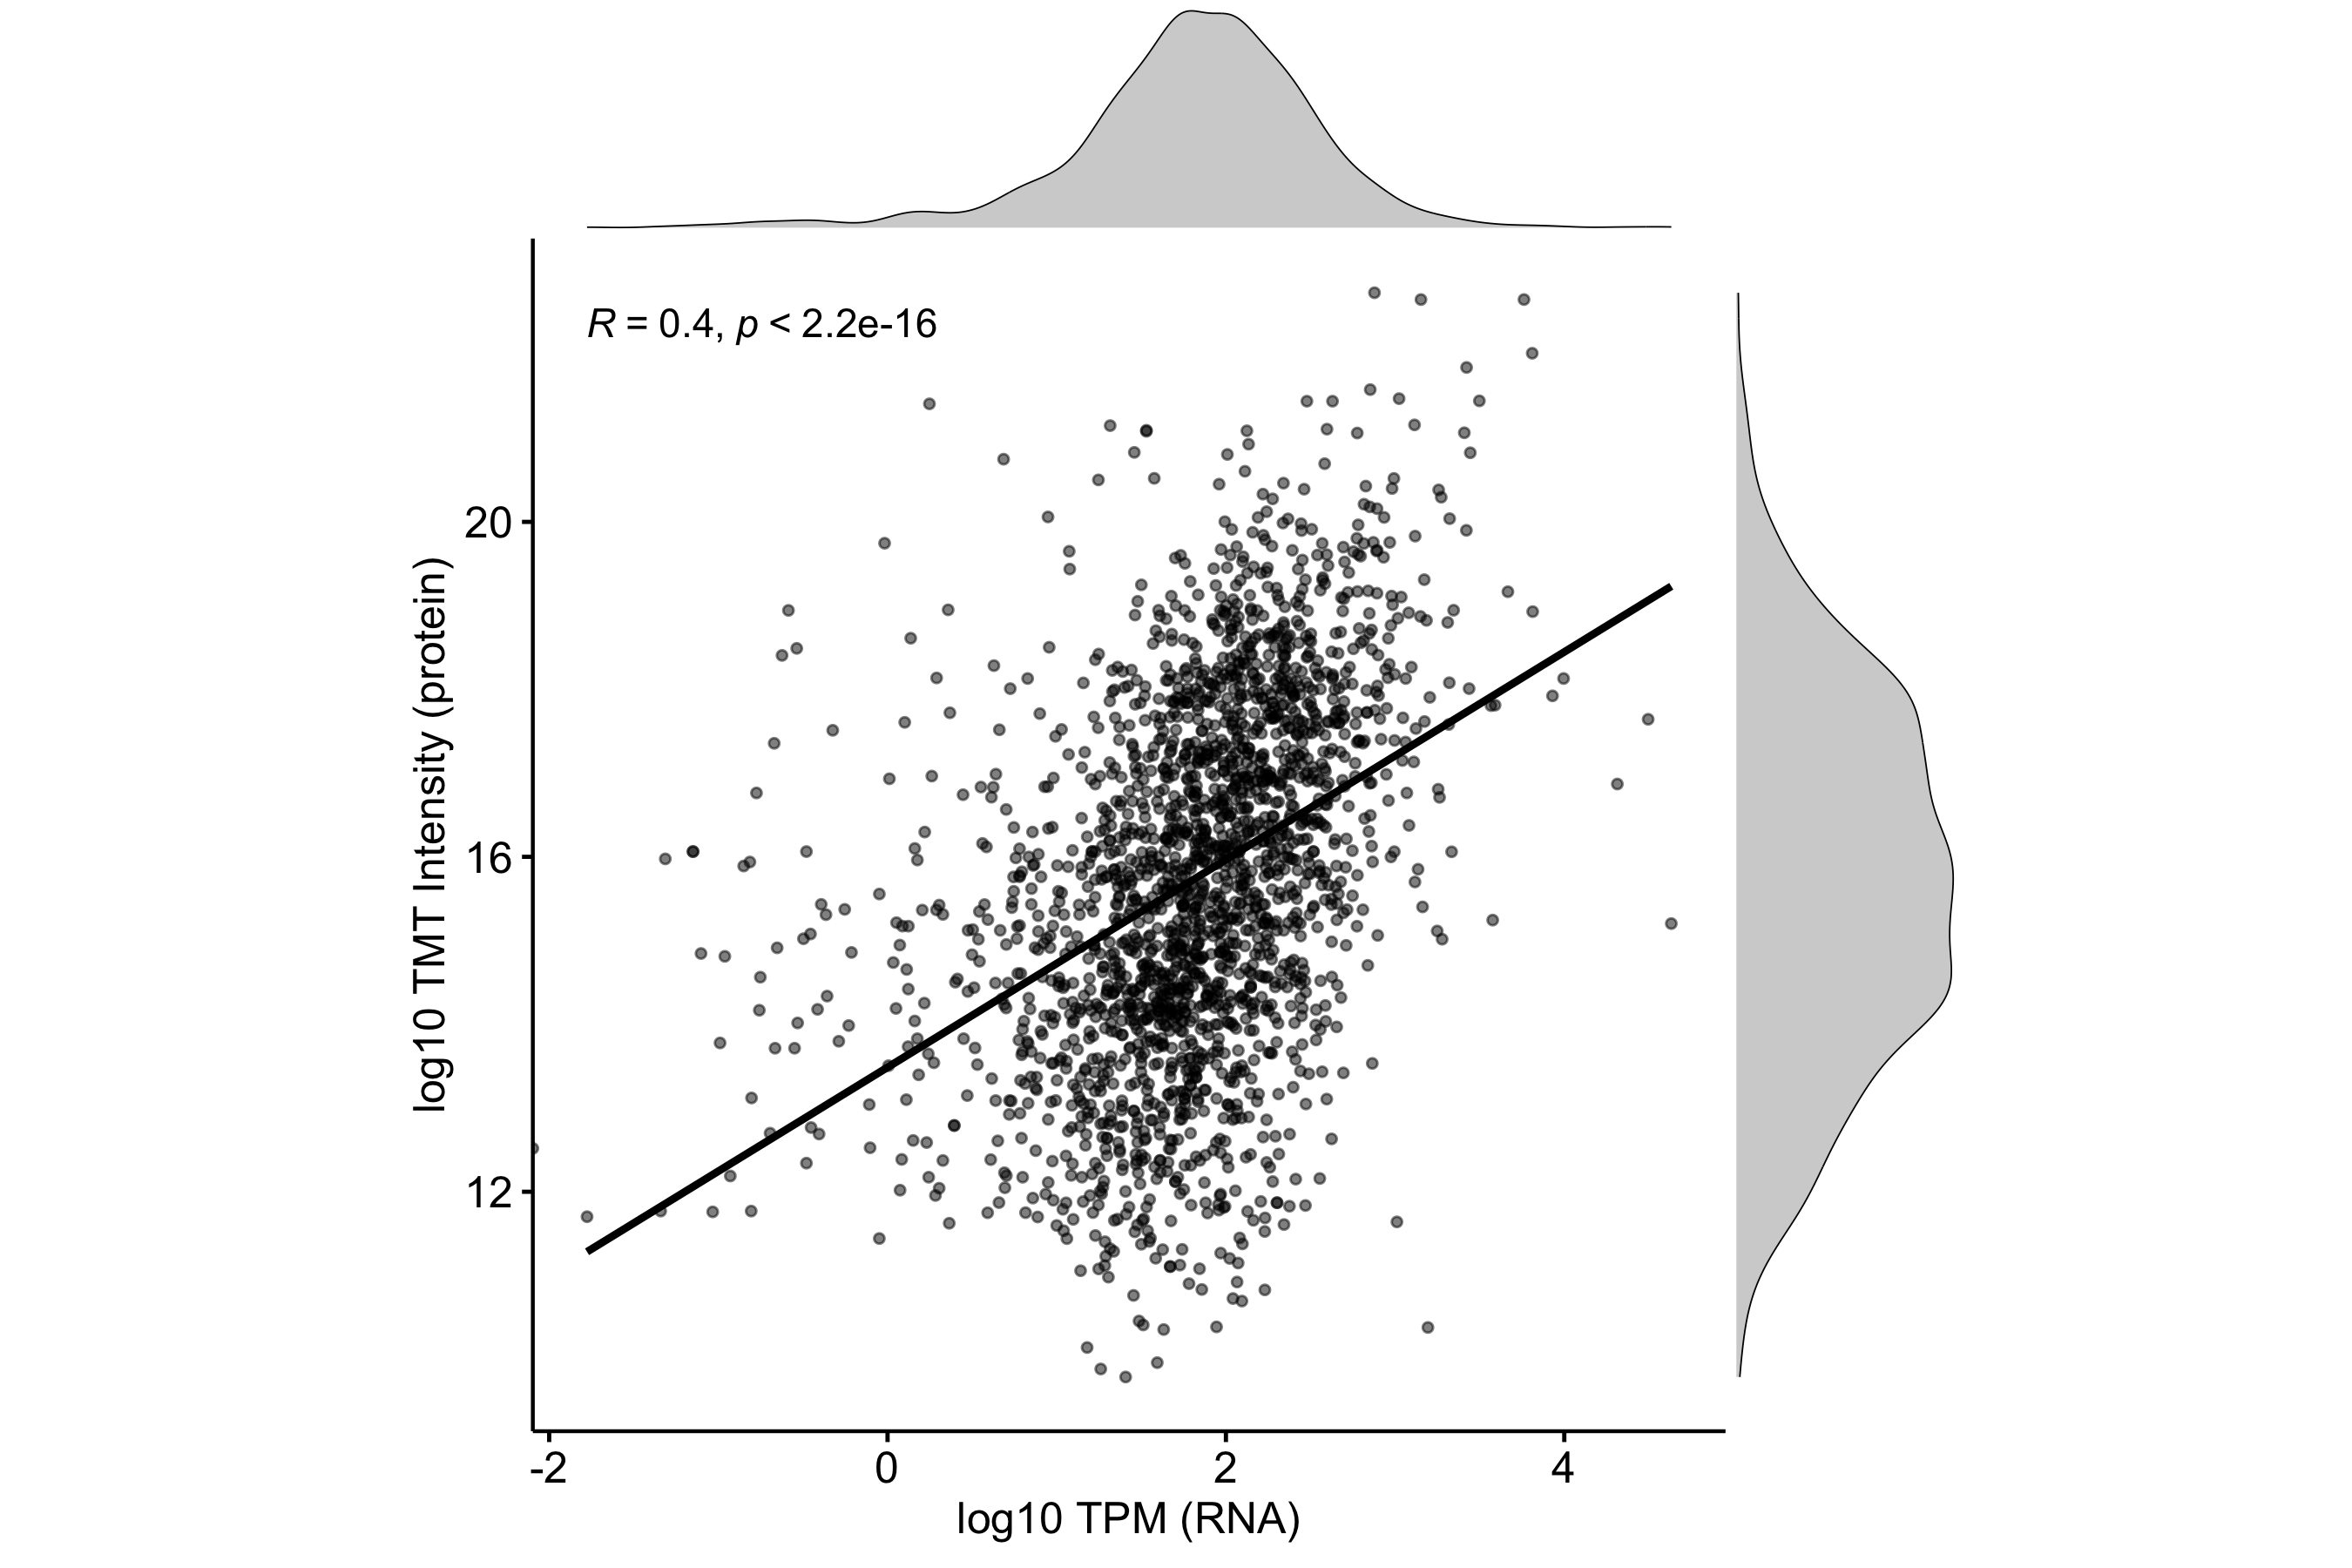

In [61]:
%%R -w 9 -h 6 --units in -r 300
# create scatter plot showing correlation between average TPM and average TMT intensity for each protein-gene pair for the PBS samples
ggscatterhist(
 merge.df, x = "log10_pbs_tpm", y = "VEH_abundance",
    alpha = 0.5, color = "black", shape = 19,
   fill = "black", size = 1,
    xlab = "log10 TPM (RNA)", ylab = "log10 TMT Intensity (protein)",
    ggtheme = theme_pubr() + theme(aspect.ratio = 1), 
    cor.coef = TRUE, cor.method = "pearson", add = "reg.line",
 margin.params = list(fill = "gray", color = "black", size = 0.2)
) 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


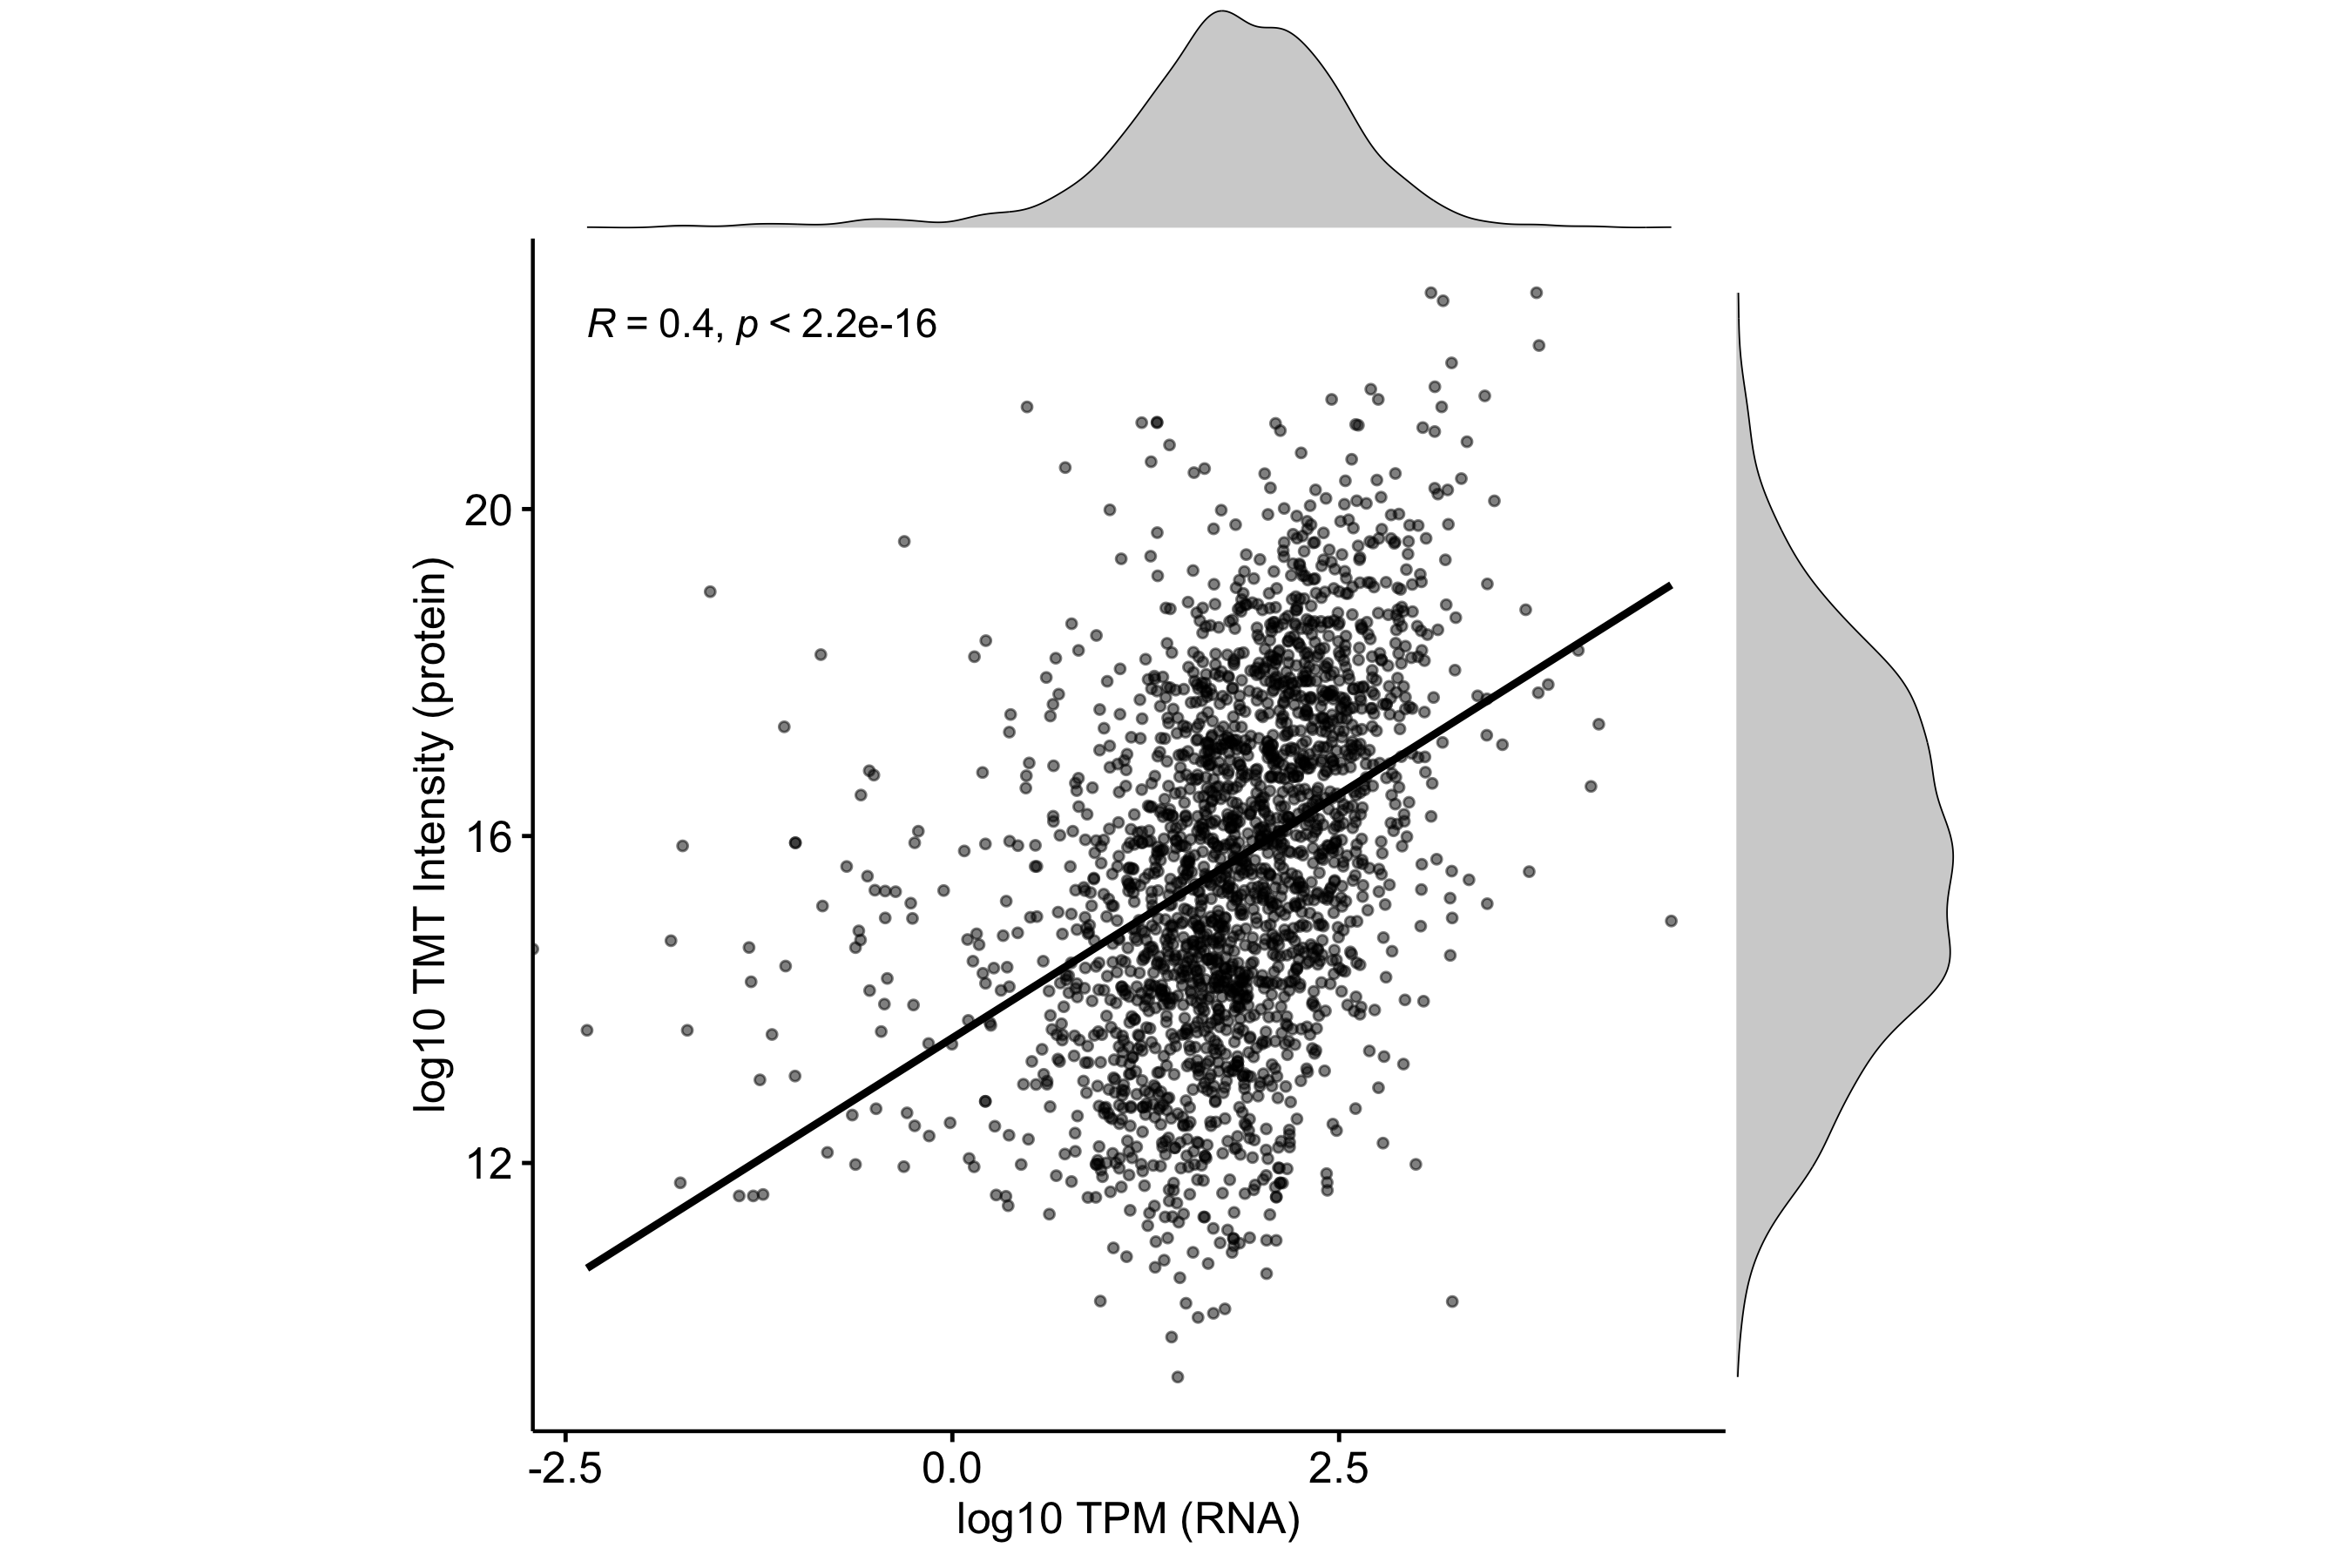

In [62]:
%%R -w 9 -h 6 --units in -r 300
# create scatter plot showing correlation between average TPM and average TMT intensity for each protein-gene pair for the TICI samples
ggscatterhist(
 merge.df, x = "log10_tici_tpm", y = "TICI_abundance",
    alpha = 0.5, color = "black", shape = 19,
   fill = "black", size = 1,
    xlab = "log10 TPM (RNA)", ylab = "log10 TMT Intensity (protein)",
    ggtheme = theme_pubr() + theme(aspect.ratio = 1), 
    cor.coef = TRUE, cor.method = "pearson", add = "reg.line",
 margin.params = list(fill = "gray", color = "black", size = 0.2)
) 


In [63]:
%%R
# print results for protein-gene pairs for which the log2FC's are significant and in the same direction
print(merge.df[merge.df$Significance == "Both (concordant)(n = 67)",], n= 68)

# A tibble: 67 × 23
# Rowwise: 
   gene_n…¹ protein log2FC    pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
   <chr>    <chr>    <dbl>   <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 Abhd4    Q8VD66  -0.196 2.80e-2   15.6  15.9   15.6   15.7  15.9   15.7  15.8
 2 Akap2    Q5U301   0.570 4.60e-3   15.3  14.9   15.4   15.5  14.8   15.4  14.9
 3 Ass1     P09034   0.689 4.73e-3   15.6  15.3   16.0   15.6  15.1   15.8  14.8
 4 Atad1    Q505J9   0.306 3.70e-2   16.5  16.2   16.2   16.7  16.2   16.5  16.1
 5 B2m      P07151   1.45  1.43e-6   18.5  17.1   18.3   18.4  17.0   18.6  16.8
 6 Bst2     Q811A2   1.48  5.11e-5   15.3  14.1   14.9   15.6  13.7   15.1  13.5
 7 Cadm4    Q1WIM1  -0.490 1.28e-2   15.1  15.3   14.8   15.3  15.8   15.2  15.6
 8 Caprin1  Q5M9G3   0.347 3.61e-3   18.2  17.7   18.0   18.2  17.8   18.0  17.7
 9 Ccl7     Q9QXY8   1.32  7.94e-4   14.9  14.3   15.9   15.2  14.2   15.9  14.1
10 Cd44     P26051   0.373 3.29e-2   16.5  16.4   17.0   16.7  16.5   17.1  1

In [64]:
%%R
# print results for protein-gene pairs for which the log2FC's are significant and in the opposite direction
print(merge.df[merge.df$Significance == "Both (discordant)(n = 8)",], n= 10)

# A tibble: 8 × 23
# Rowwise: 
  gene_na…¹ protein log2FC    pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
  <chr>     <chr>    <dbl>   <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
1 A2m       P06238  -0.556 2.43e-2   12.1  12.5   11.6   12.2  12.7   11.5  12.2
2 Adsl      P54822  -0.264 4.48e-2   14.2  14.5   13.9   14.1  14.3   14.2  14.3
3 Dnah12    Q923J6   0.840 4.36e-5   14.7  13.9   14.4   14.8  13.8   14.5  13.6
4 Dvl3      Q61062   0.391 4.22e-2   11.0  10.7   10.8   11.1  10.9   11.2  10.3
5 Lgals3    P08699  -0.410 3.99e-2   18.5  18.7   17.9   18.6  19.0   18.2  18.6
6 Pdlim4    P36202  -0.422 1.62e-2   17.1  17.3   16.6   17.1  17.4   16.8  17.3
7 Psmb6     P28073  -0.296 3.45e-2   15.4  15.7   15.5   15.6  15.9   15.6  15.8
8 Sord      P27867   0.669 5.16e-5   14.0  13.3   14.0   14.3  13.5   14.0  13.4
# … with 12 more variables: TICI_5 <dbl>, VEH_5 <dbl>, log2FoldChange <dbl>,
#   padj <dbl>, significance <fct>, Significance <fct>, pbs_tpm <dbl>,
#   tici_tp

In [65]:
%%R
# print results for protein-gene pairs for which the protein is differentially abundant but the gene is not differentially expressed
print(merge.df[merge.df$Significance == "Protein only (n = 14)",], n= 15)

# A tibble: 14 × 23
# Rowwise: 
   gene_n…¹ protein log2FC    pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
   <chr>    <chr>    <dbl>   <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 Aifm1    Q9Z0X1   0.244 0.0247    14.5  14.3   14.2   14.6  14.2   14.4  14.1
 2 Amdhd2   Q5BJY6   0.633 0.00198   10.9  10.8   10.9   11.0  10.2   11.0  10.3
 3 Arhgap1  Q5FWK3   0.418 0.0387    13.7  13.2   13.0   13.5  12.8   13.2  12.8
 4 Dnase2   Q9QZK8  -0.293 0.0471    14.1  14.4   13.7   14.2  14.5   13.9  14.1
 5 Gja1     P08050  -0.749 0.00498   14.5  15.0   14.4   14.7  15.6   14.4  15.1
 6 Impa1    P97697   0.269 0.0149    14.7  14.5   14.5   14.7  14.4   14.6  14.2
 7 Itga6    Q61739  -0.361 0.0334    12.5  12.9   12.4   12.7  12.9   12.4  12.8
 8 Nup98    P49793  -0.250 0.00357   11.3  11.7   11.4   11.5  11.6   11.4  11.6
 9 Psap     P10960  -0.225 0.0356    19.8  19.9   19.6   19.9  20.2   19.9  20.0
10 Ralgapb  P86410  -0.198 0.0200    12.8  13.0   12.8   13.0  13.0   12.7  1

In [66]:
%%R
# print results for protein-gene pairs for which the gene is differentially expressed but the protein is not differentially abundant
print(merge.df[merge.df$Significance == "RNA only (n = 966)",], n= 15)

# A tibble: 966 × 23
# Rowwise: 
   gene_n…¹ protein   log2FC  pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
   <chr>    <chr>      <dbl> <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 Abat     P50554  -5.34e-2 0.716   18.5  18.5   18.7   18.9  18.9   18.9  18.9
 2 Abhd12   Q6AYT7  -1.61e-1 0.467   15.2  15.4   14.4   15.2  15.2   14.9  14.7
 3 Abhd17b  Q6AY17  -1.75e-1 0.142   12.4  12.7   12.2   12.4  12.6   12.5  12.7
 4 Abi1     Q9QZM5  -3.72e-2 0.749   14.0  13.9   14.0   14.0  14.2   13.9  14.0
 5 Acaa2    P13437  -1.30e-1 0.371   16.0  16.2   16.2   16.3  16.4   16.4  16.4
 6 Acadl    P15650  -1.09e-4 1.00    18.1  18.1   18.5   18.4  18.6   18.7  18.6
 7 Acadm    P08503   9.91e-2 0.480   15.8  15.7   16.0   15.9  15.9   16.1  15.9
 8 Acadvl   P45953  -8.36e-2 0.569   17.6  17.8   18.0   17.9  18.1   18.0  18.1
 9 Acap2    Q5FVC7  -6.07e-2 0.651   14.1  14.0   14.1   14.0  14.2   14.2  14.2
10 Acat1    P17764  -1.23e-1 0.290   17.3  17.5   17.1   17.5  17.5   17.3  

In [67]:
%%R
# print results for protein-gene pairs for which the gene is differentially expressed but the protein is not differentially abundant
print(merge.df[merge.df$Significance == "Neither (n = 1099)",], n= 15)

# A tibble: 1,099 × 23
# Rowwise: 
   gene_n…¹ protein  log2FC   pval TICI_1 VEH_1 TICI_2 TICI_3 VEH_3 TICI_4 VEH_4
   <chr>    <chr>     <dbl>  <dbl>  <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 Aarsd1   Q5XI97  -0.122  0.574    16.1  16.3   15.4   16.0  15.8   15.5  15.6
 2 Aasdhppt B2RYJ4  -0.122  0.361    13.3  13.4   12.9   13.3  13.2   13.0  13.1
 3 Abcb7    Q704E8  -0.127  0.316    13.5  13.3   12.9   13.3  13.5   13.2  13.3
 4 Abcd3    P16970  -0.0190 0.918    17.4  17.4   17.8   17.7  17.9   18.0  17.9
 5 Abce1    P61222  -0.197  0.0644   17.1  17.2   16.8   17.1  17.3   17.0  17.2
 6 Abcf1    Q6MG08  -0.0806 0.664    13.0  13.2   12.7   13.3  13.2   13.0  13.0
 7 Abcf3    Q66H39   0.0765 0.576    15.4  15.3   14.9   15.3  15.1   15.1  15.0
 8 Abhd6    Q5XI64  -0.131  0.519    11.2  11.4   10.8   11.4  11.4   11.5  11.1
 9 Abr      A0A0G2… -0.0376 0.859    11.9  12.0   11.7   12.7  12.1   11.9  12.2
10 Abr      Q5SSL4  -0.0376 0.859    11.9  12.0   11.7   12.7  12.1   11.9

In [68]:
%%R
# save CSV files with results
write.csv(merge.df[merge.df$Significance == "Both (concordant)(n = 67)",], "relative_file_path/output_files/concordant_results.csv")
write.csv(merge.df[merge.df$Significance == "Both (discordant)(n = 8)",], "relative_file_path/output_files/discordant_results.csv")
write.csv(merge.df[merge.df$Significance == "Protein only (n = 14)",], "relative_file_path/output_files/protein_only_results.csv")
write.csv(merge.df[merge.df$Significance == "RNA only (n = 966)",], "relative_file_path/output_files/rna_only_results.csv")
write.csv(merge.df[merge.df$Significance == "Neither (n = 1099)",], "relative_file_path/output_files/neither_results.csv")

In [69]:
%%R
# save objects
saveRDS(tx2gene, "relative_file_path/output_files/tx2gene_dictionary.rds")
saveRDS(txi, "relative_file_path/output_files/tximport_object.rds")
saveRDS(ddsTxi, "relative_file_path/output_files/deseq2Txi_object.rds")

saveRDS(dds, "relative_file_path/output_files/deseq2_object.rds")
saveRDS(ddssva, "relative_file_path/output_files/deseq2_object_sva_corrected.rds")
saveRDS(rld, "relative_file_path/output_files/rld_matrix.rds")

saveRDS(TICI.v.PBS.sva, "relative_file_path/output_files/deseq2_results_object.rds")
saveRDS(sig.TICI.v.PBS.sva, "relative_file_path/output_files/significant_TICI_vs_PBS_degs_deseq2_results.rds")

In [70]:
%%R
# save merged results object
saveRDS(merge.df, "relative_file_path/output_files/merged_protein_gene_comparison_dataframe_with_protein_names.rds")

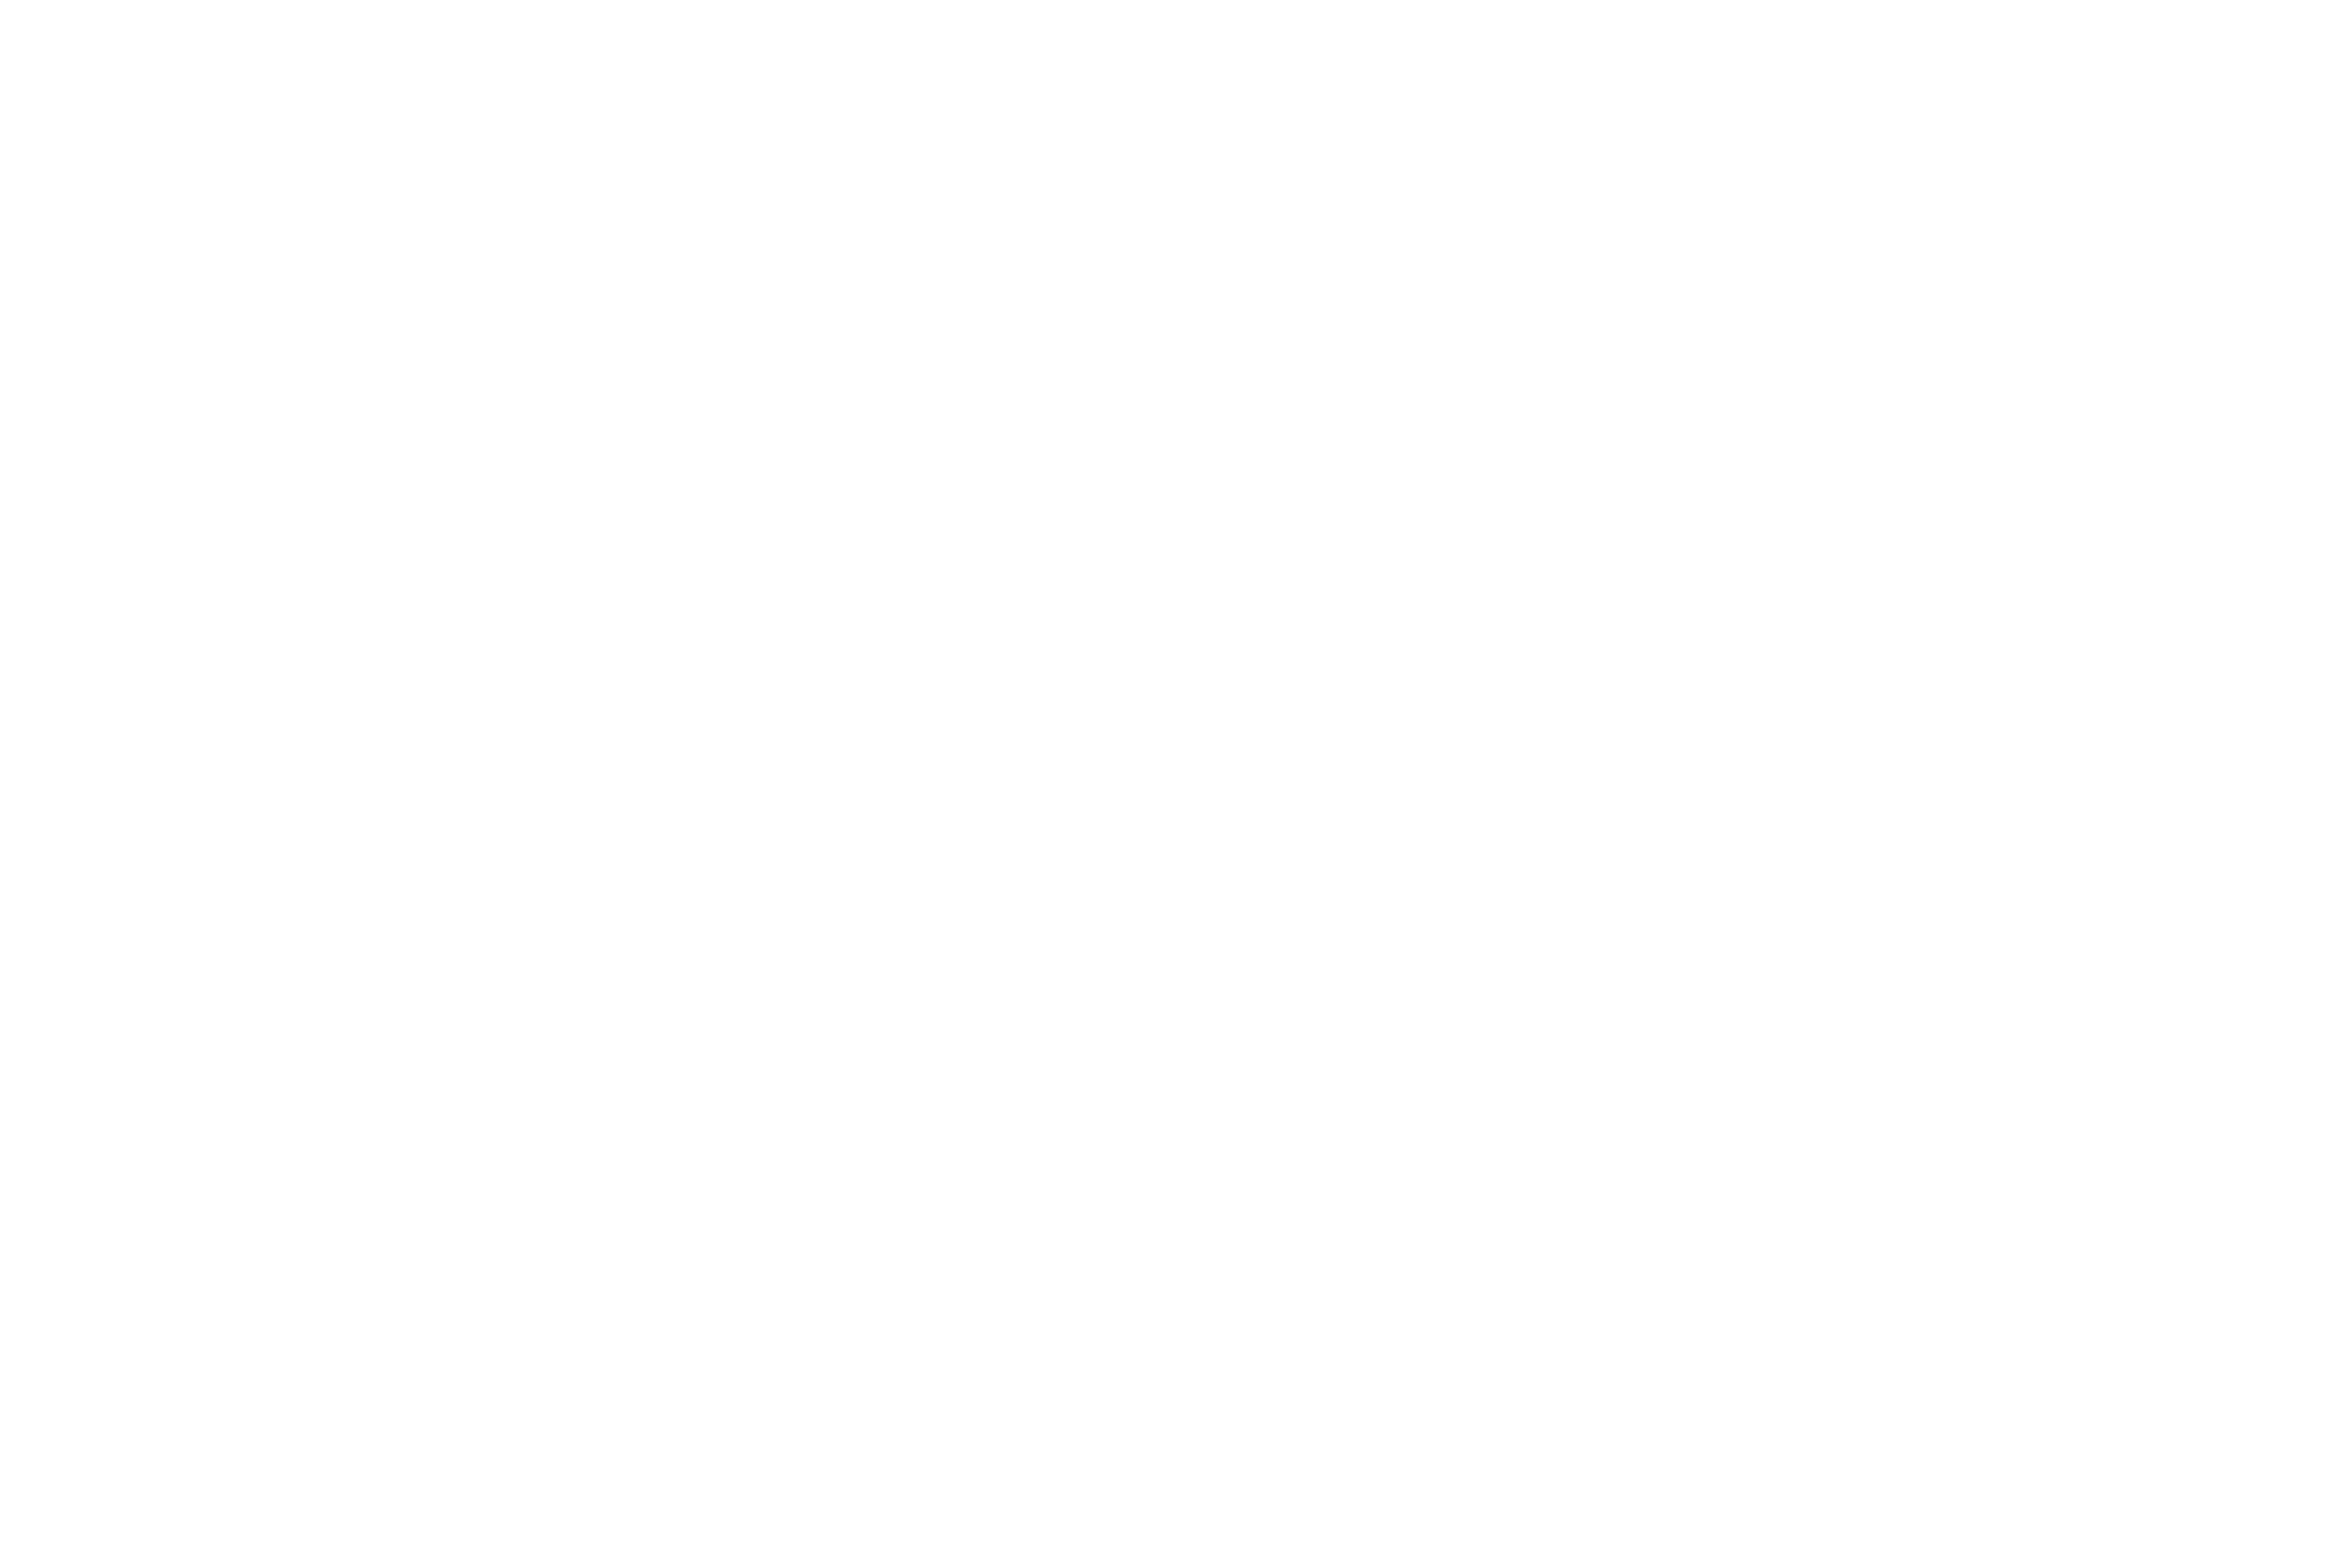

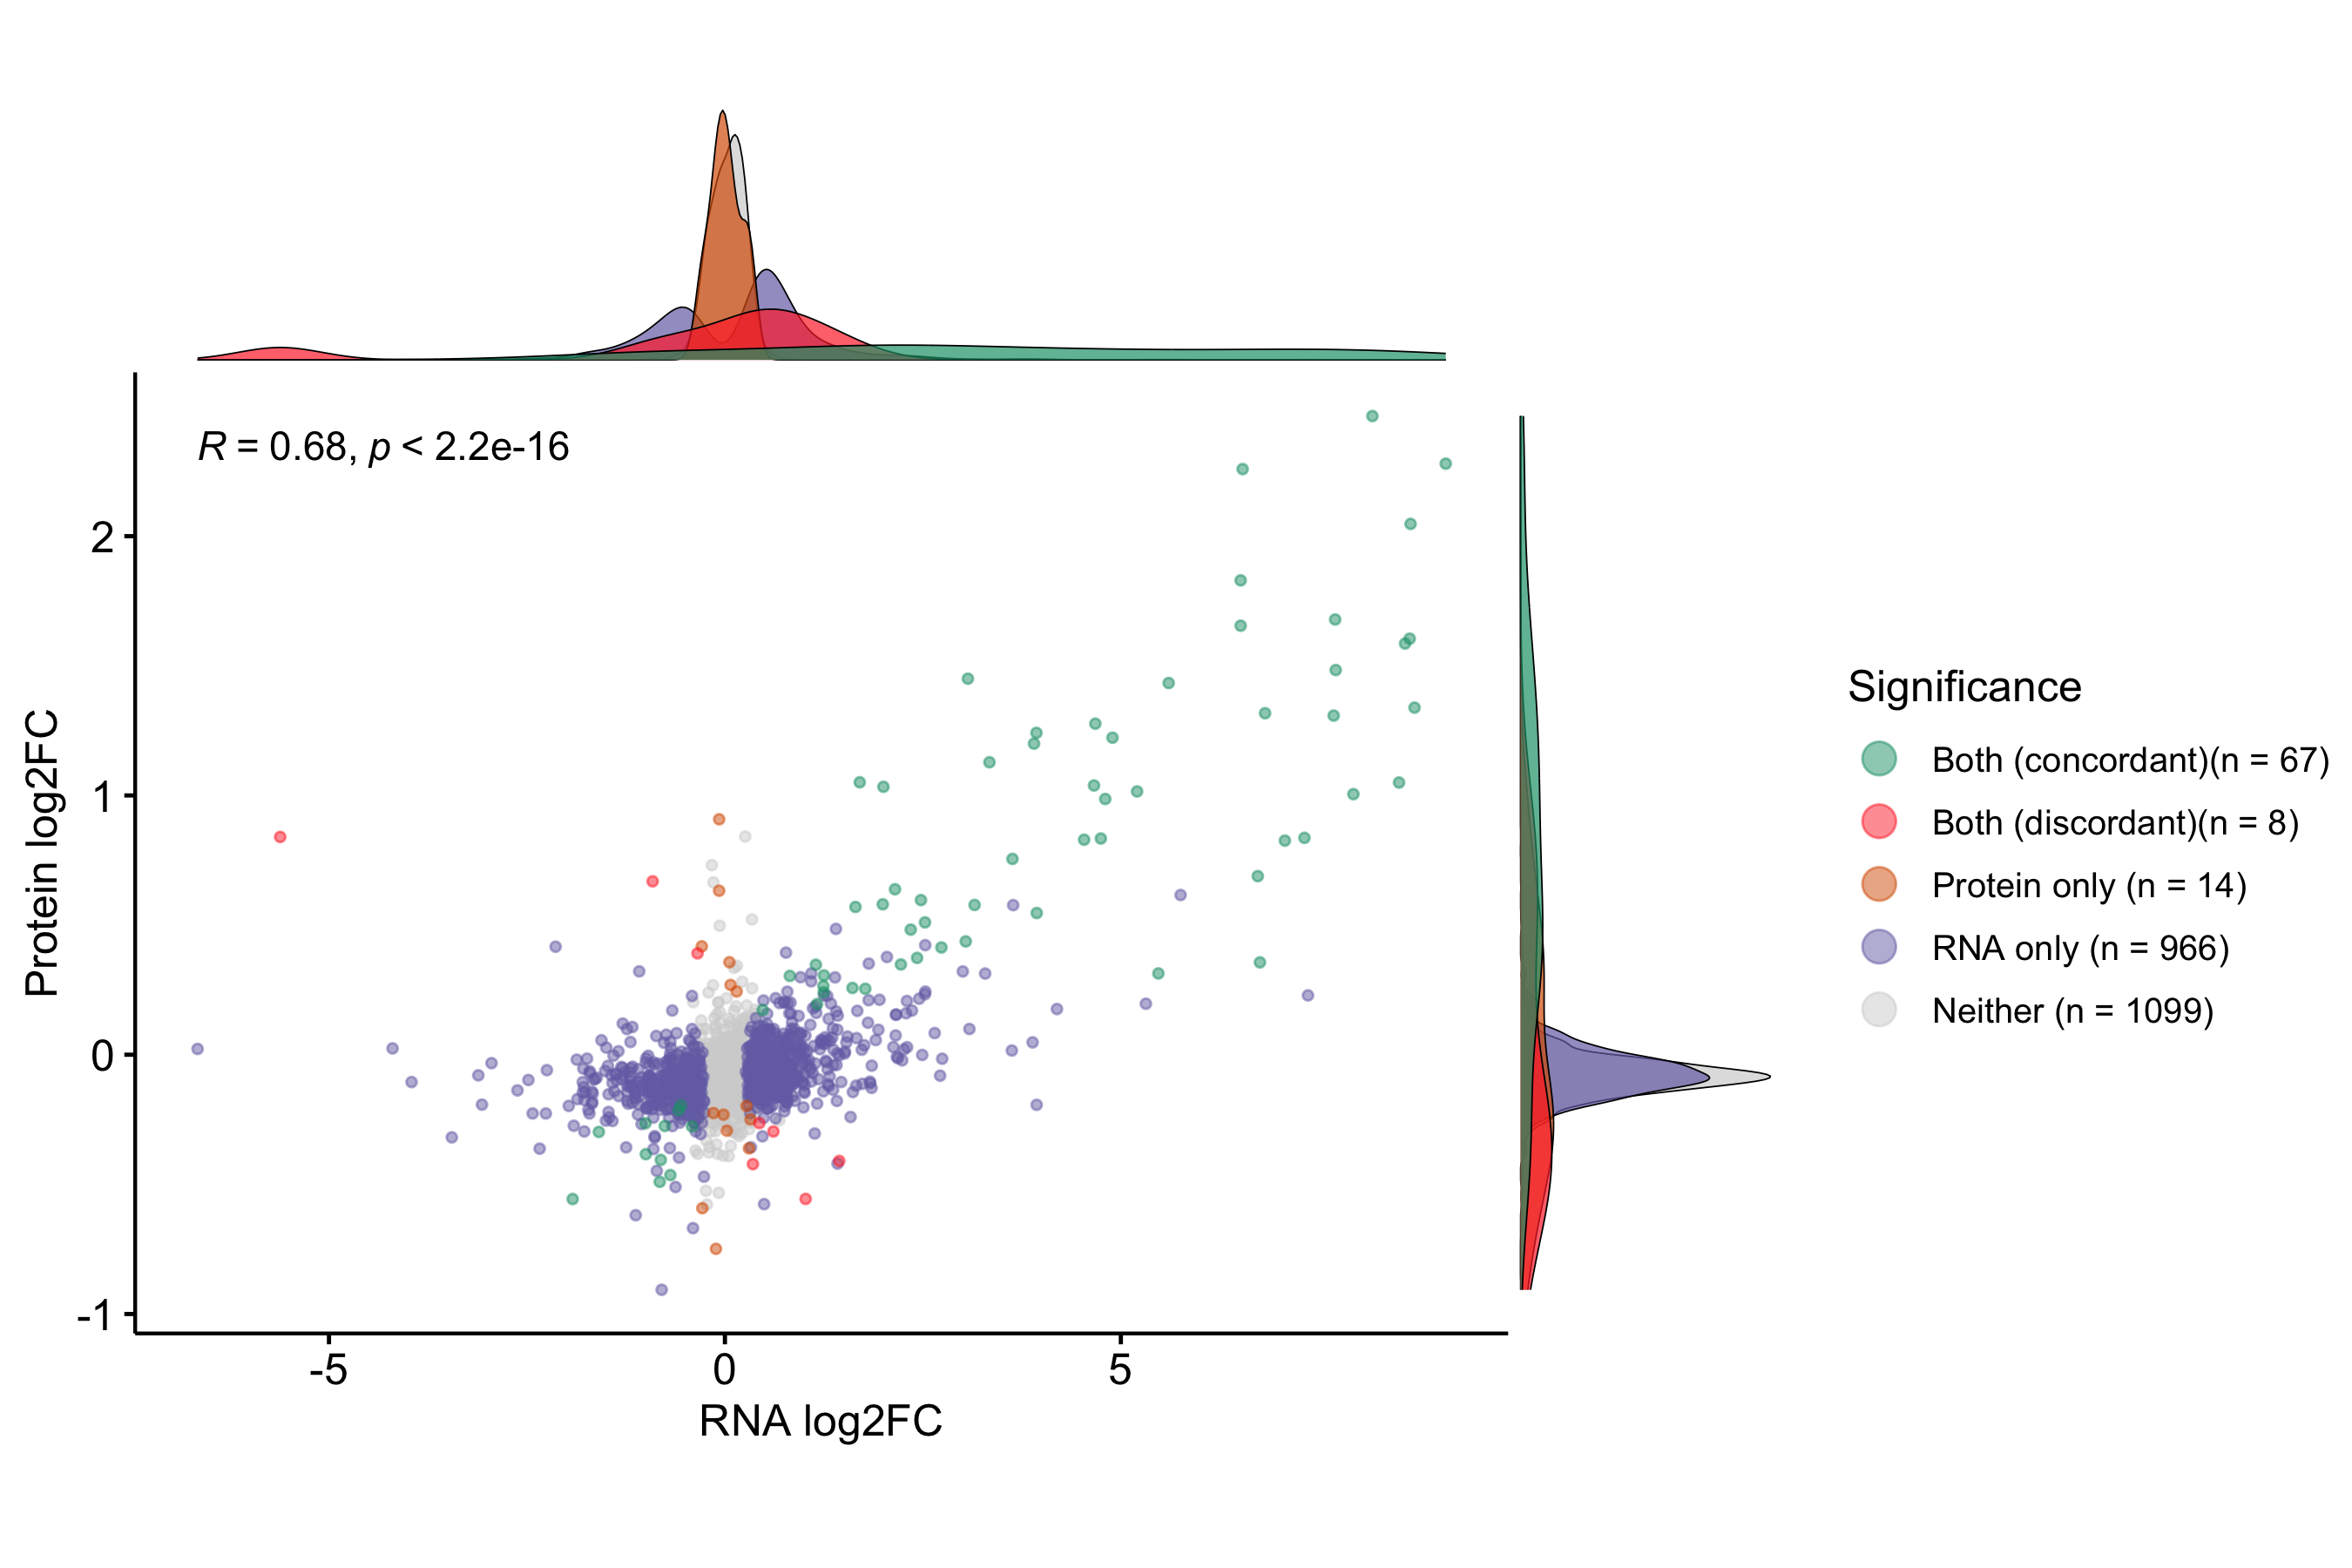

In [71]:
%%R -w 9 -h 6 --units in -r 300
# plot log2FC scatterplot comparing protein and gene changes in TICI versus PBS samples, and their agreement
plot <- ggscatterhist(
 merge.df %>% arrange(significance), x = "log2FoldChange", y = "log2FC",
    alpha = 0.5, color = "Significance", shape = 19,
   fill = "Significance", size = 1, palette = c("lightgray", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[1], rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[2], "#FF3333", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[3]), 
    xlab = "RNA log2FC", ylab = "Protein log2FC",
    ggtheme = theme_pubr() + theme(aspect.ratio = 0.7), 
    cor.coef = TRUE, cor.method = "pearson", print = FALSE,
 margin.params = list(fill = "Significance", color = "black", size = 0.2), legend = "right"
) 

plot$sp <- plot$sp + guides(color = guide_legend(reverse = TRUE, override.aes = list(size=4)), fill = FALSE)

plot

In [72]:
%%R -w 9 -h 6 --units in -r 300

ggexport(plot, filename = "relative_file_path/output_files/main_l2fc_plot.pdf")

R[write to console]: file saved to relative_file_path/output_files/main_l2fc_plot.pdf



In [73]:
%%R

merge.df <- merge.df %>% mutate(select_label = ifelse(Significance == "Both (concordant)(n = 67)", gene_names, NA))

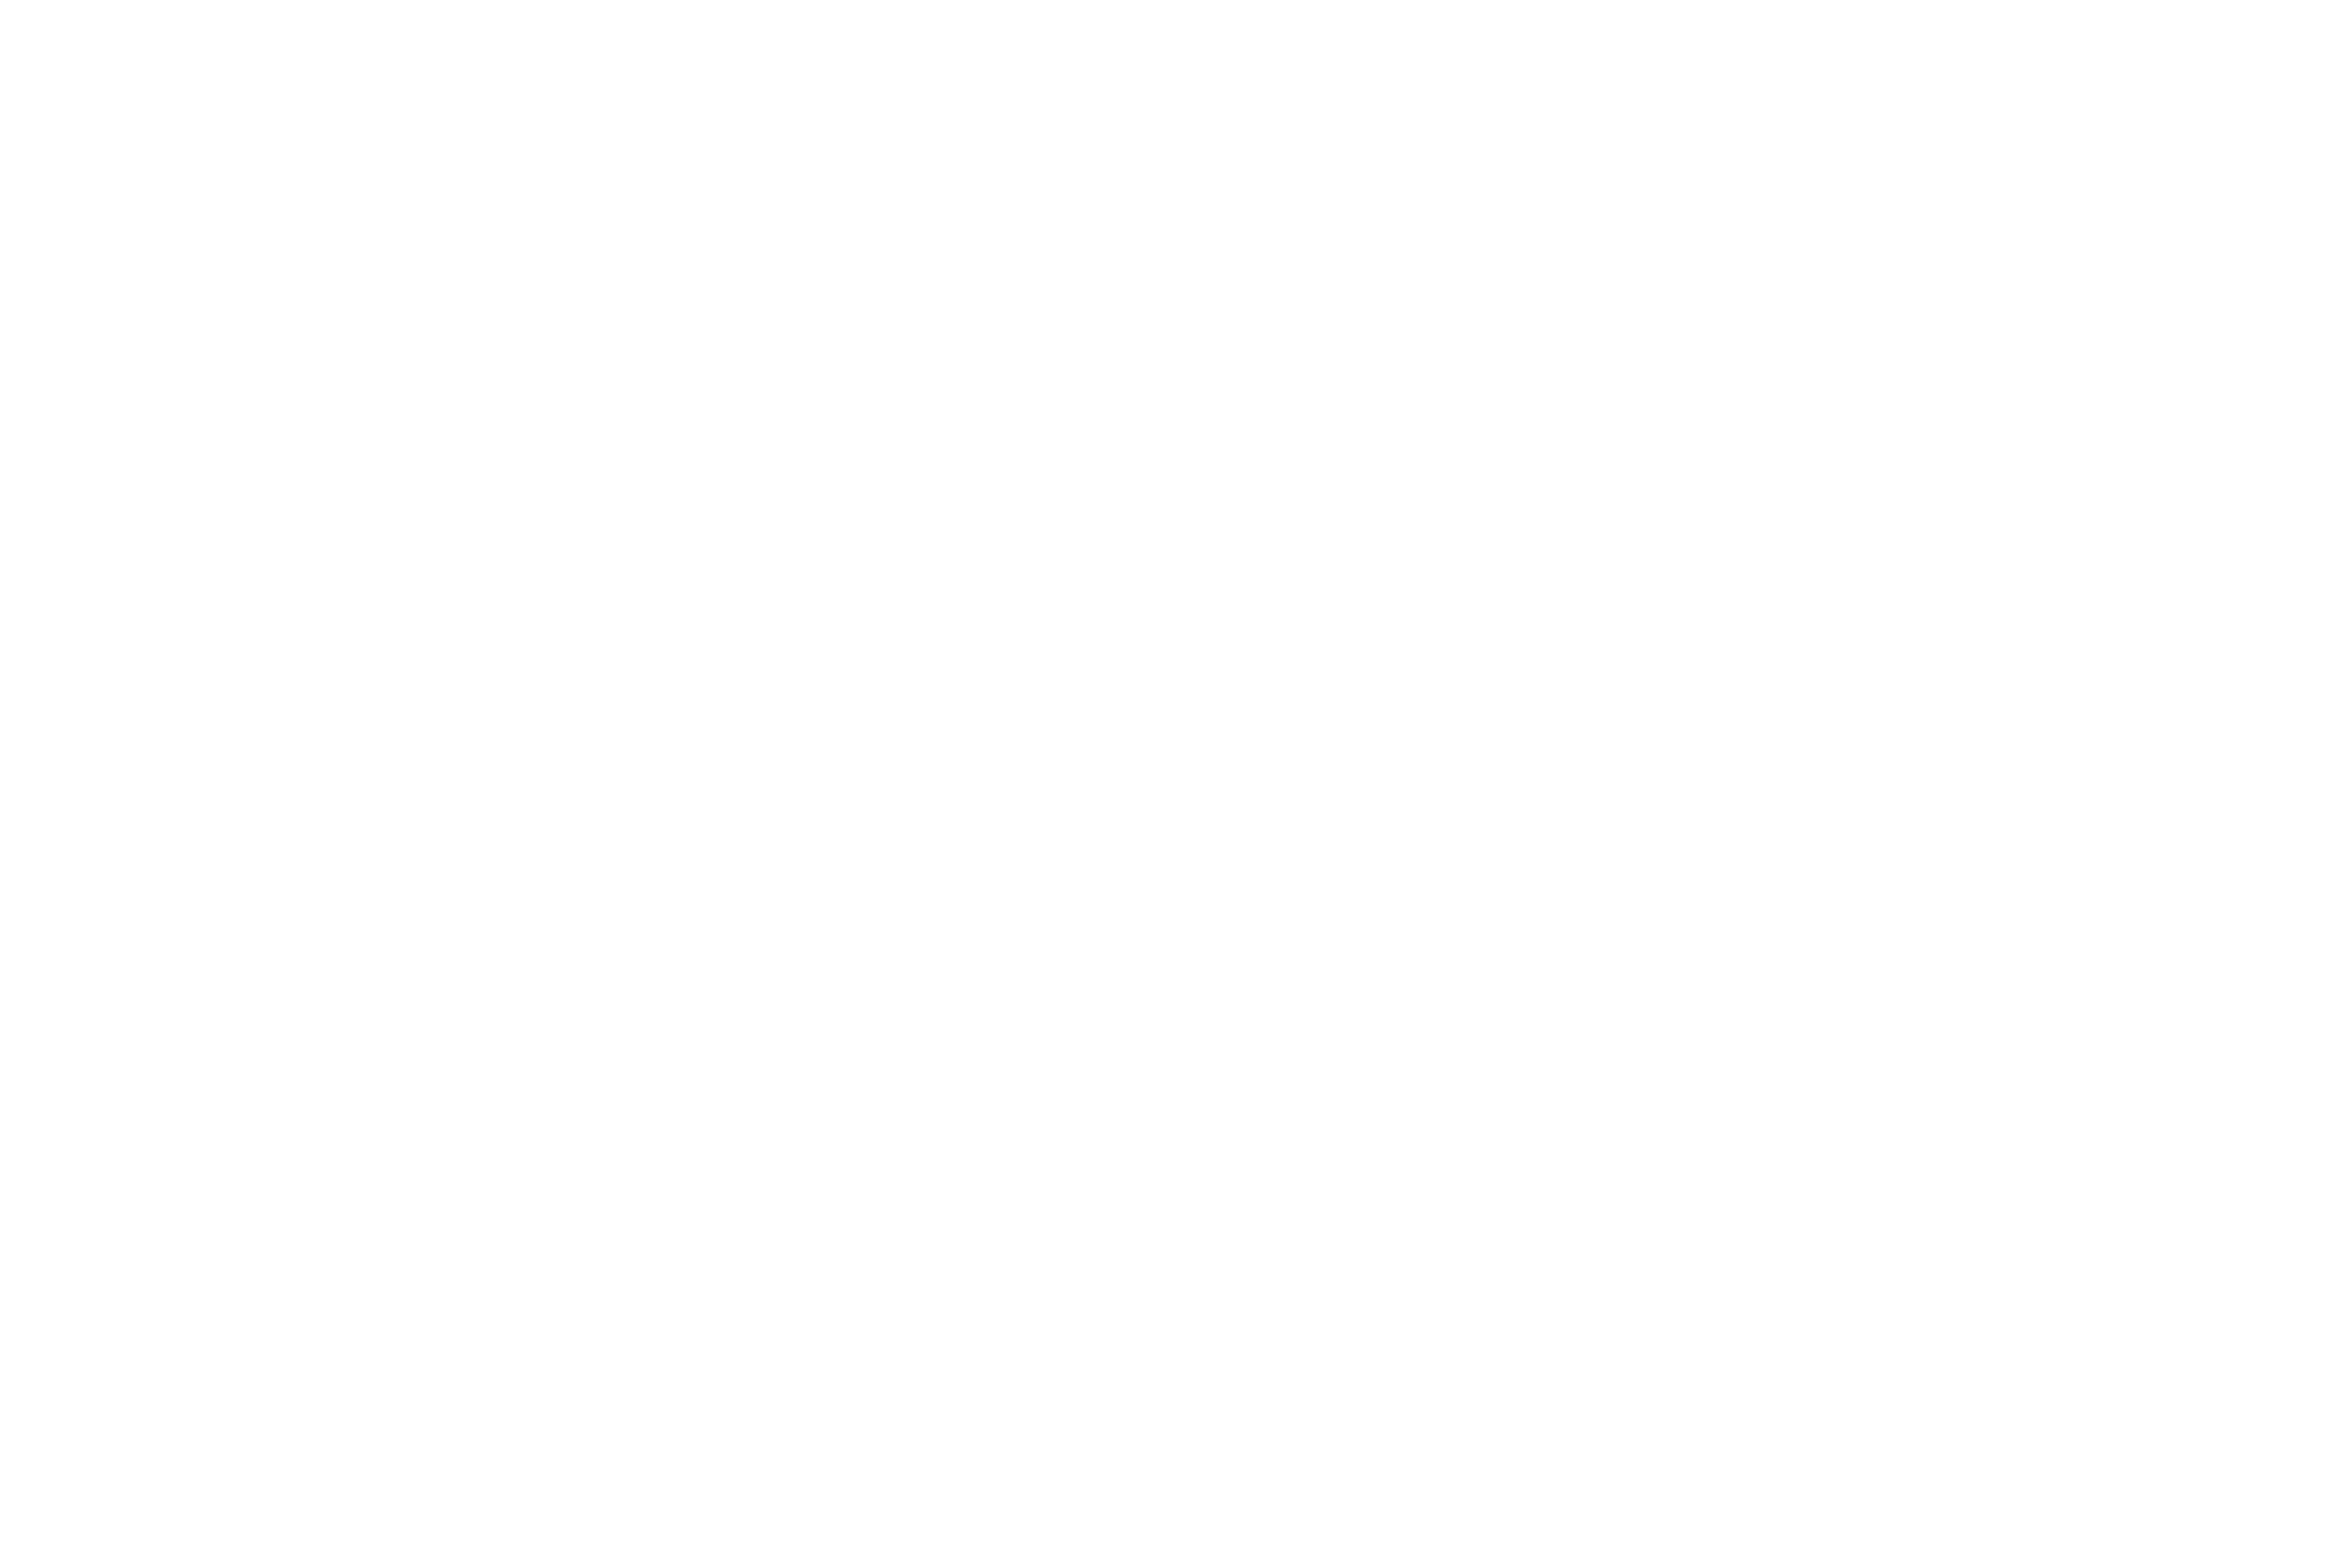

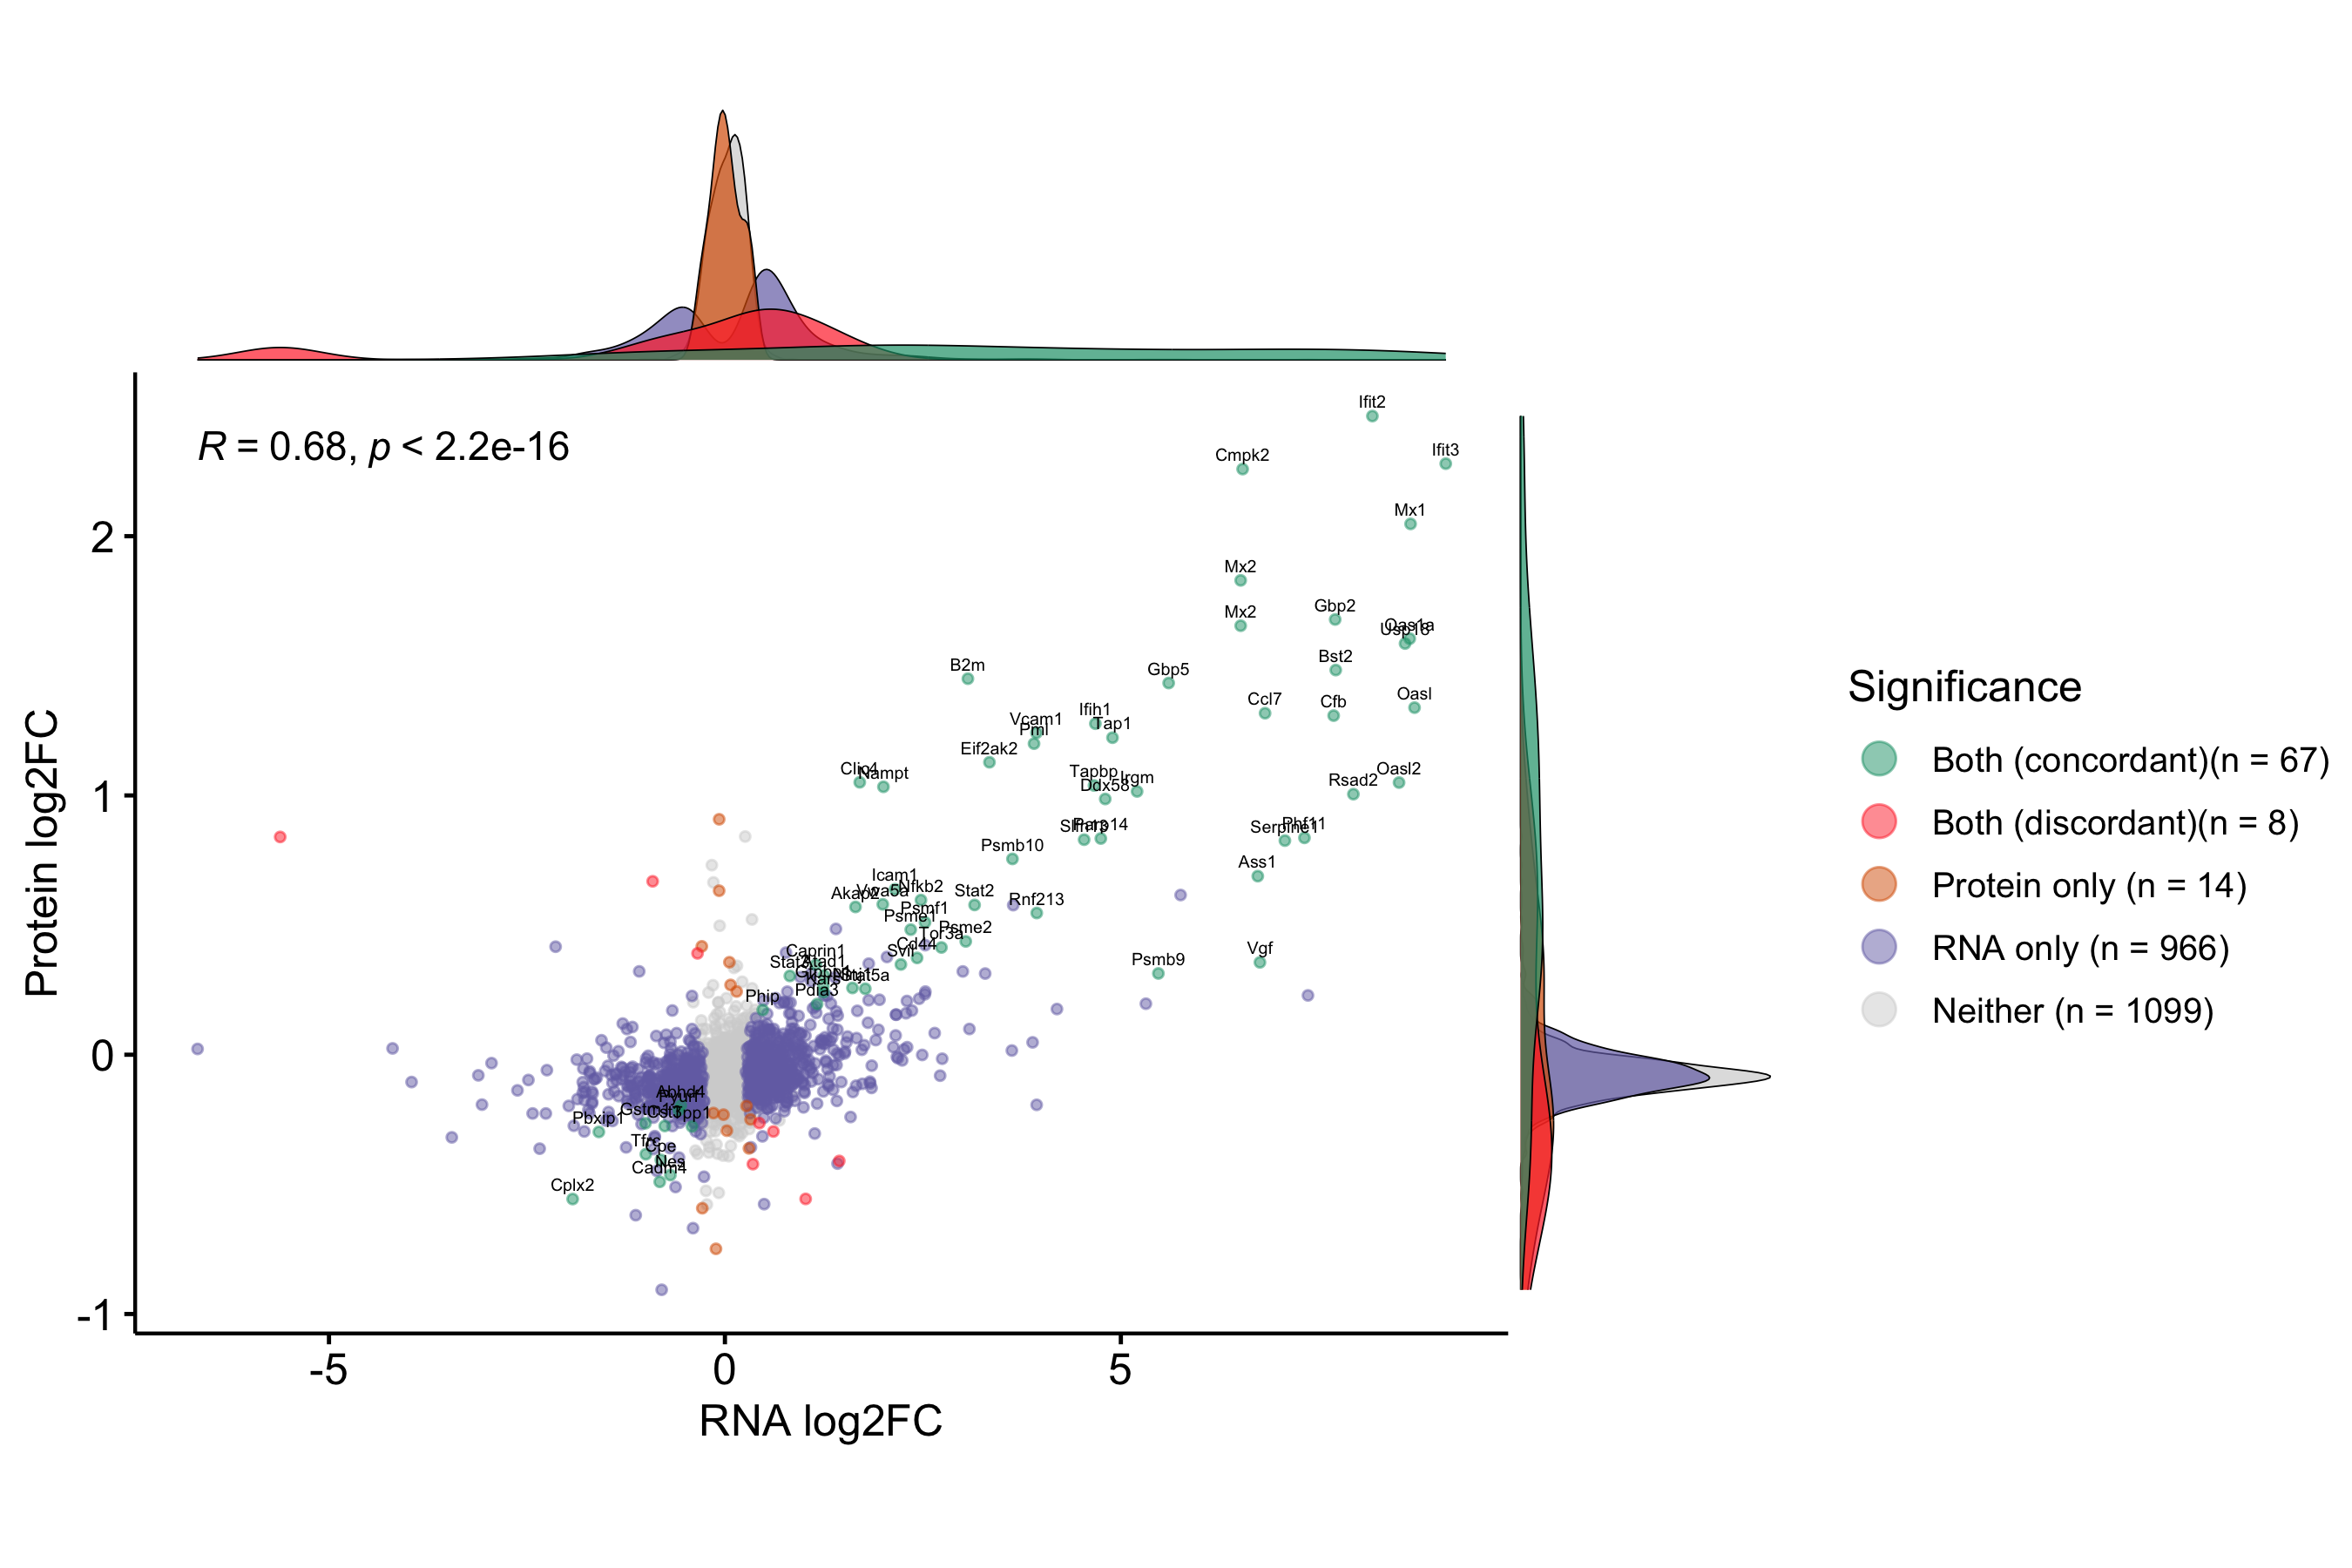

In [74]:
%%R -w 9 -h 6 --units in -r 300
# plot log2FC scatterplot comparing protein and gene changes in TICI versus PBS samples, and highlight the concordant genes
plot <- ggscatterhist(
 merge.df %>% arrange(significance), x = "log2FoldChange", y = "log2FC",
    alpha = 0.5, color = "Significance", shape = 19,
   fill = "Significance", size = 1, palette = c("lightgray", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[1], rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[2], "#FF3333", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[3]), 
    xlab = "RNA log2FC", ylab = "Protein log2FC",
    ggtheme = theme_pubr() + theme(aspect.ratio = 0.7), 
    cor.coef = TRUE, cor.method = "pearson", print = FALSE,
    label = "select_label", repel = FALSE, font.label = c(5, "plain", "black"),
 margin.params = list(fill = "Significance", color = "black", size = 0.2), legend = "right"
) 

plot$sp <- plot$sp + guides(color = guide_legend(reverse = TRUE, override.aes = list(size=4)), fill = FALSE)

plot

In [75]:
%%R -w 9 -h 6 --units in -r 300

ggexport(plot, filename = "relative_file_path/output_files/l2fc_plot_both_concordant.pdf")

R[write to console]: file saved to relative_file_path/output_files/l2fc_plot_both_concordant.pdf



In [76]:
%%R

merge.df <- merge.df %>% mutate(select_label = ifelse(Significance == "Both (discordant)(n = 8)", gene_names, NA))

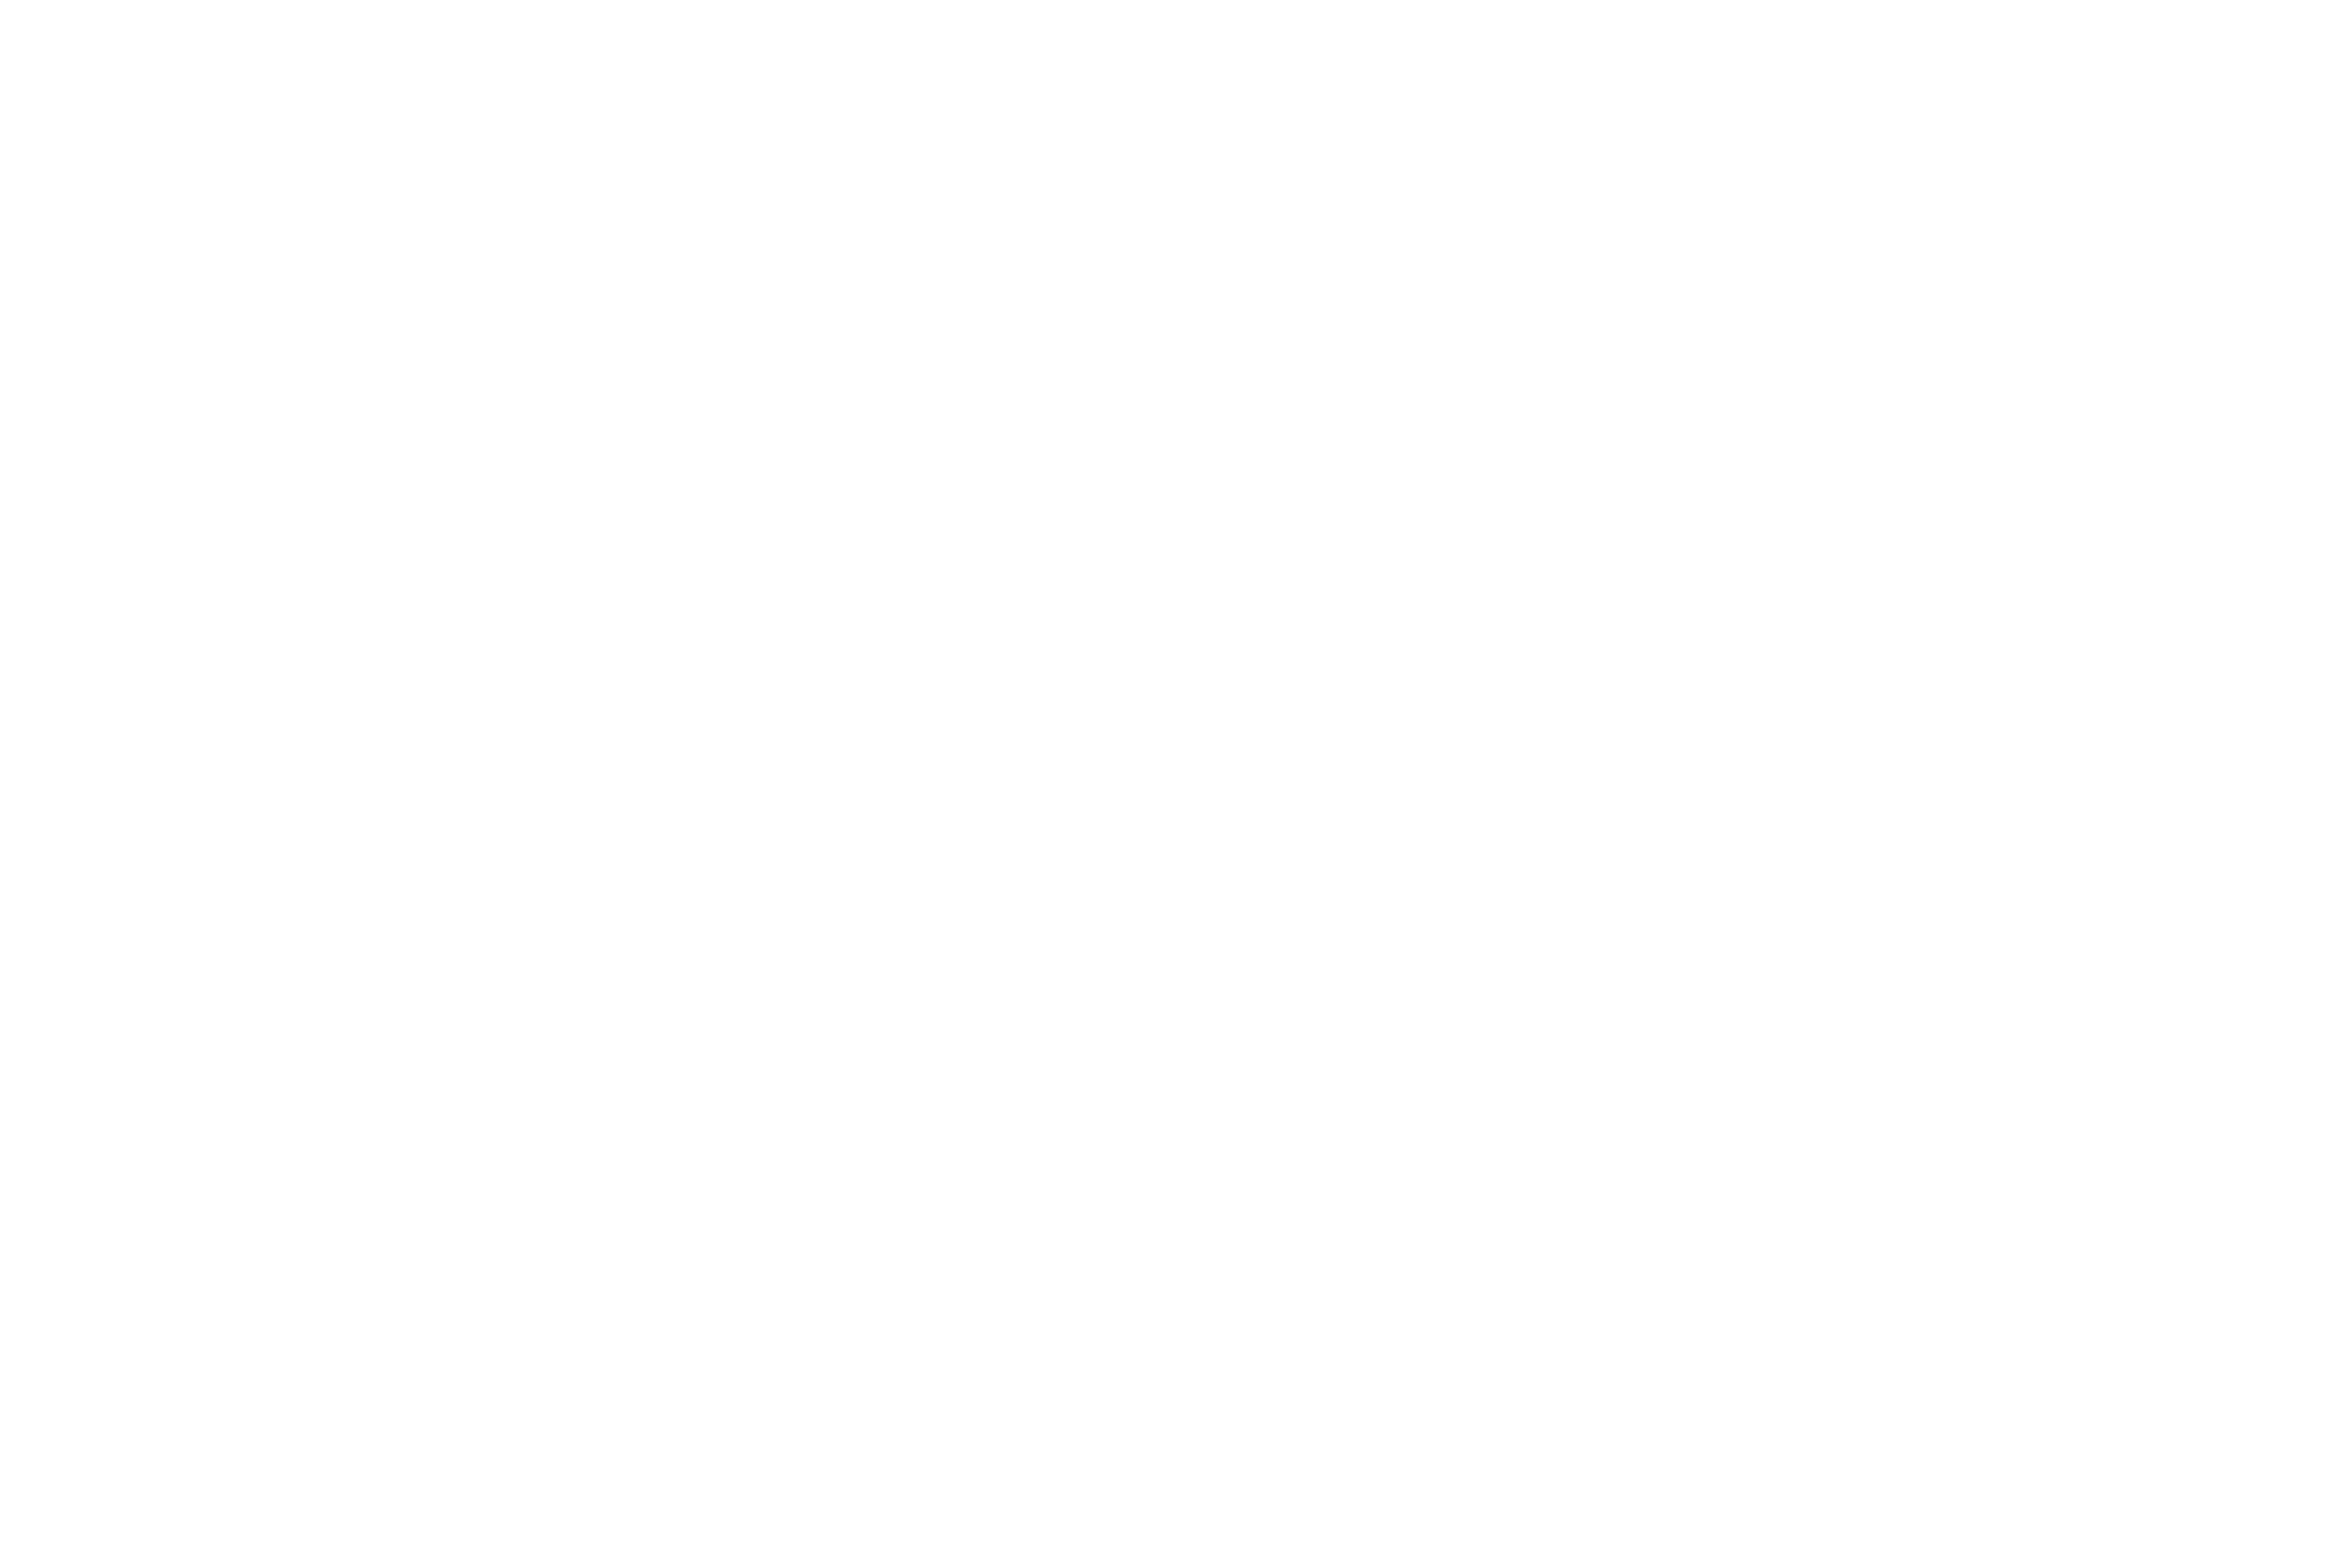

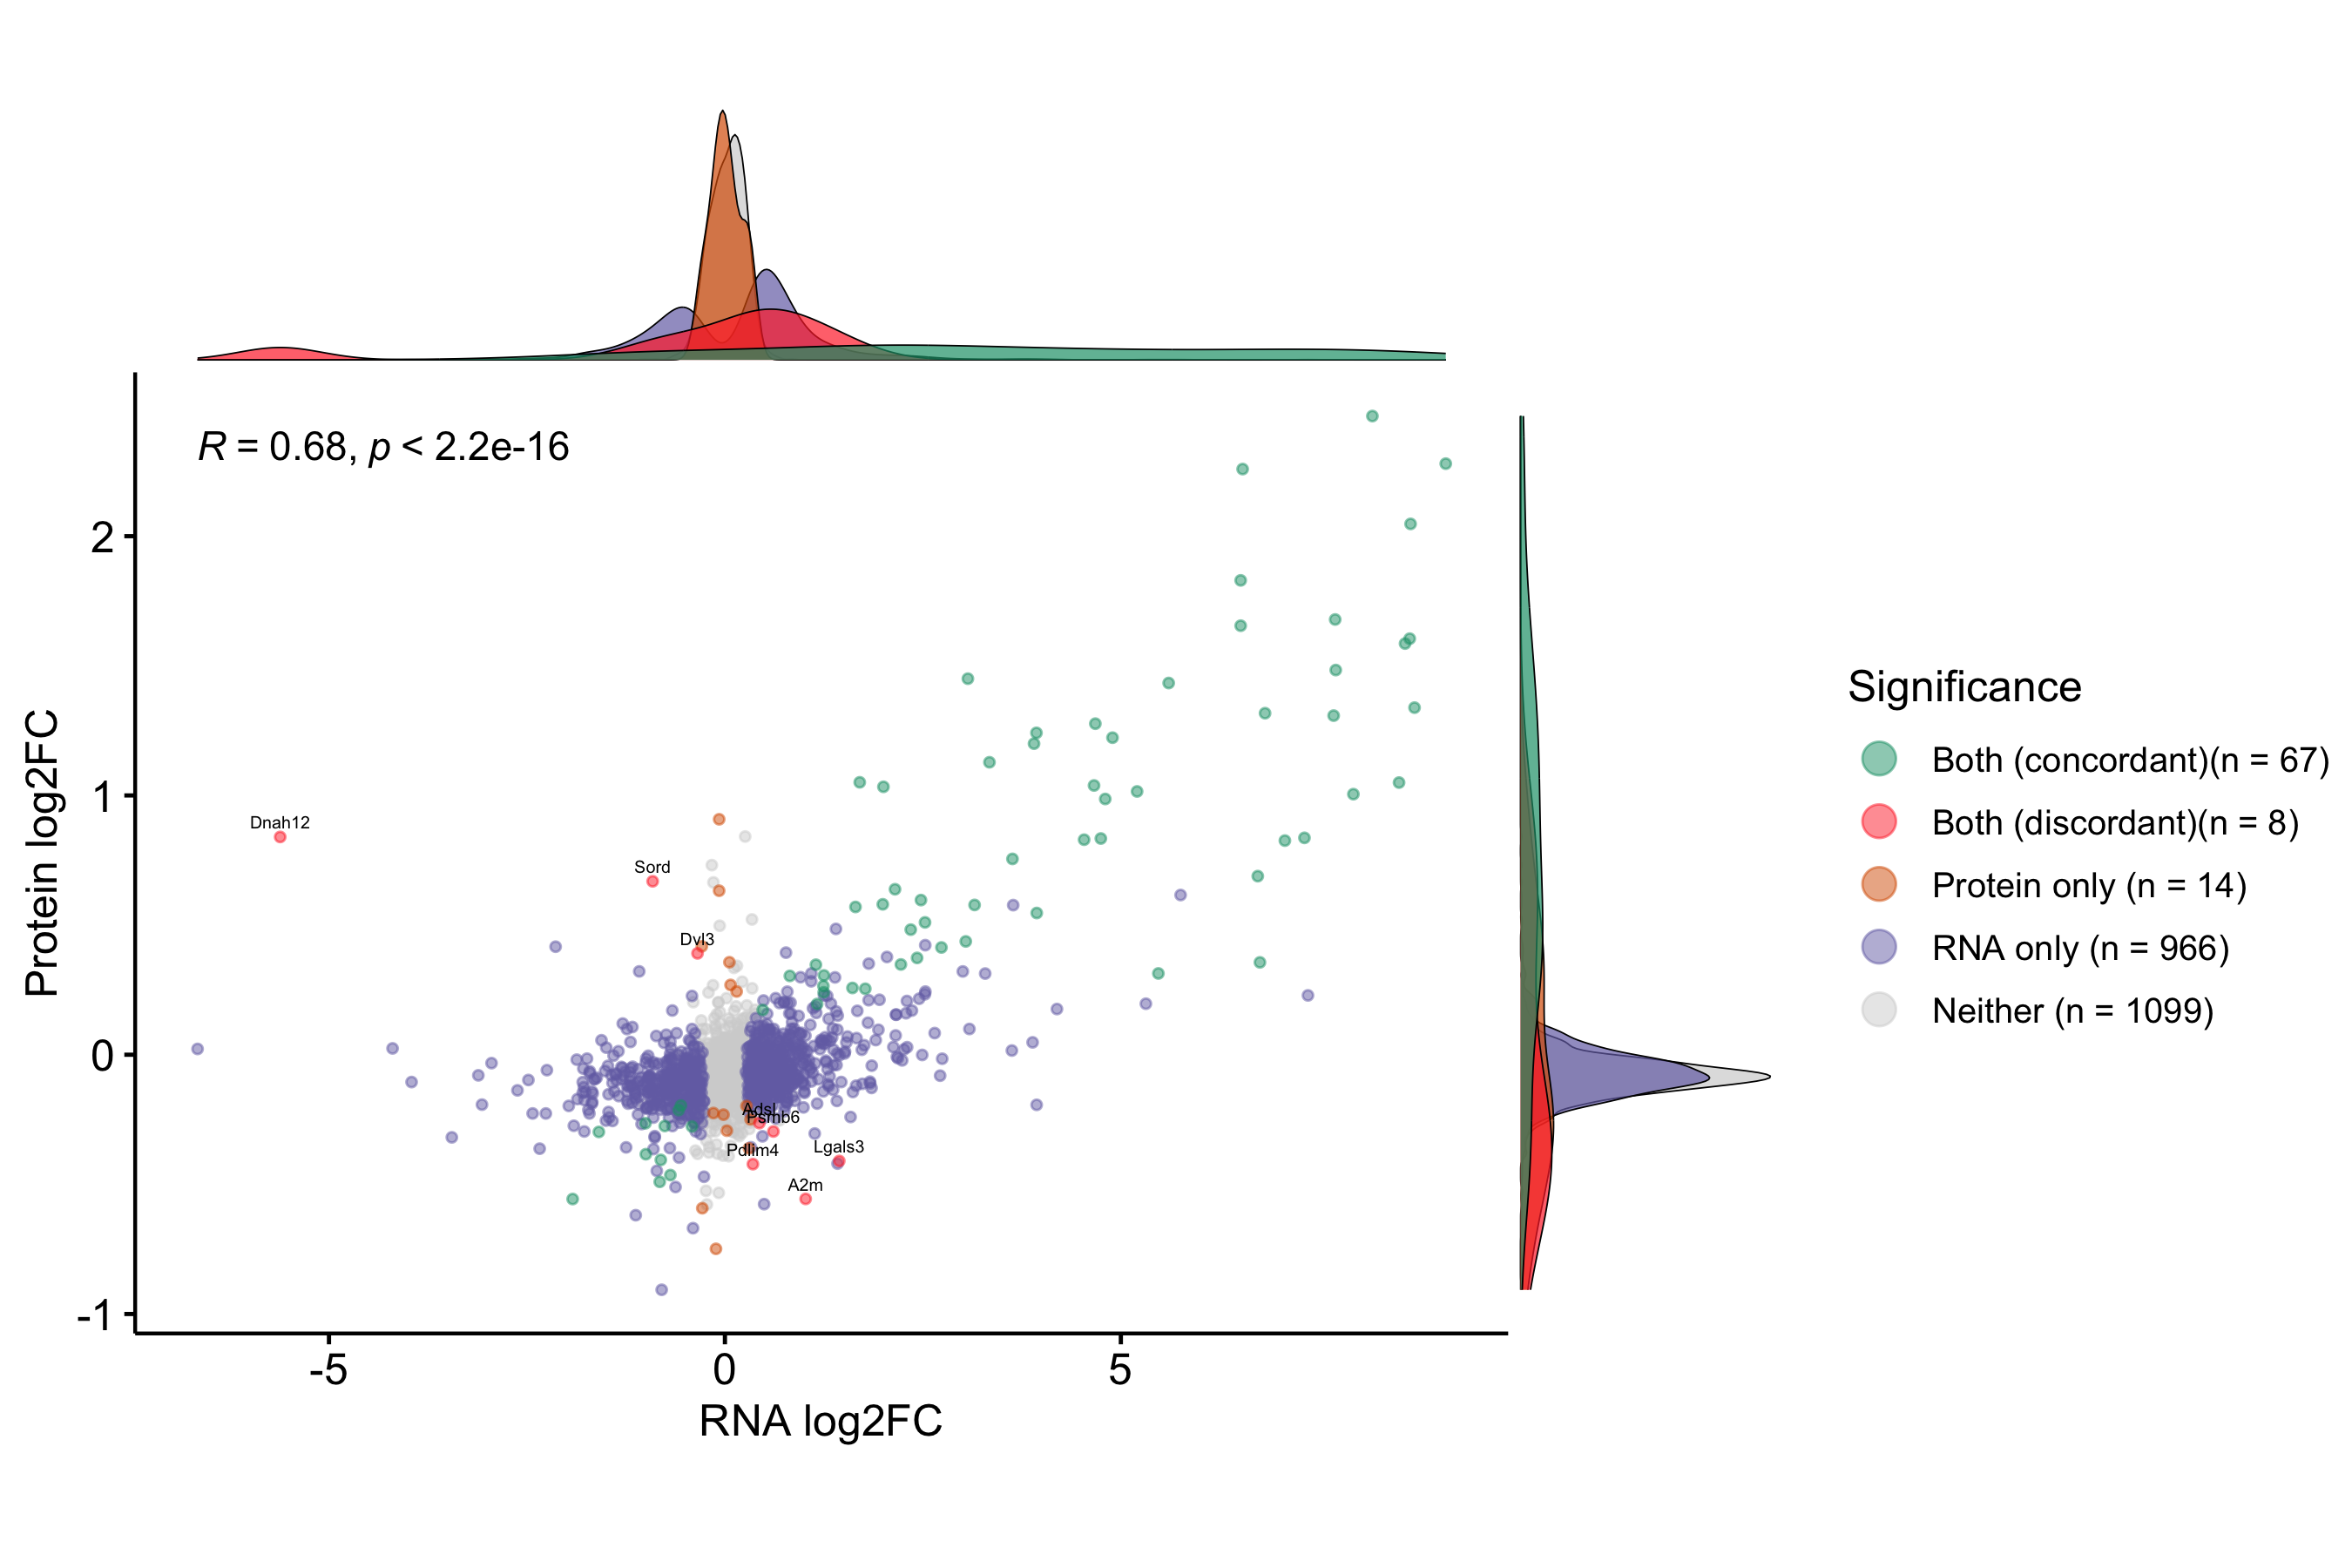

In [77]:
%%R -w 9 -h 6 --units in -r 300
# plot log2FC scatterplot comparing protein and gene changes in TICI versus PBS samples, and highlight the discordant genes
plot <- ggscatterhist(
 merge.df %>% arrange(significance), x = "log2FoldChange", y = "log2FC",
    alpha = 0.5, color = "Significance", shape = 19,
   fill = "Significance", size = 1, palette = c("lightgray", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[1], rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[2], "#FF3333", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[3]), 
    xlab = "RNA log2FC", ylab = "Protein log2FC",
    ggtheme = theme_pubr() + theme(aspect.ratio = 0.7), 
    cor.coef = TRUE, cor.method = "pearson", print = FALSE,
    label = "select_label", repel = FALSE, font.label = c(5, "plain", "black"),
 margin.params = list(fill = "Significance", color = "black", size = 0.2), legend = "right"
) 

plot$sp <- plot$sp + guides(color = guide_legend(reverse = TRUE, override.aes = list(size=4)), fill = FALSE)

plot

In [78]:
%%R -w 9 -h 6 --units in -r 300

ggexport(plot, filename = "relative_file_path/output_files/l2fc_plot_both_discordant.pdf")

R[write to console]: file saved to relative_file_path/output_files/l2fc_plot_both_discordant.pdf



In [79]:
%%R

merge.df <- merge.df %>% mutate(select_label = ifelse(Significance == "Protein only (n = 14)", gene_names, NA))

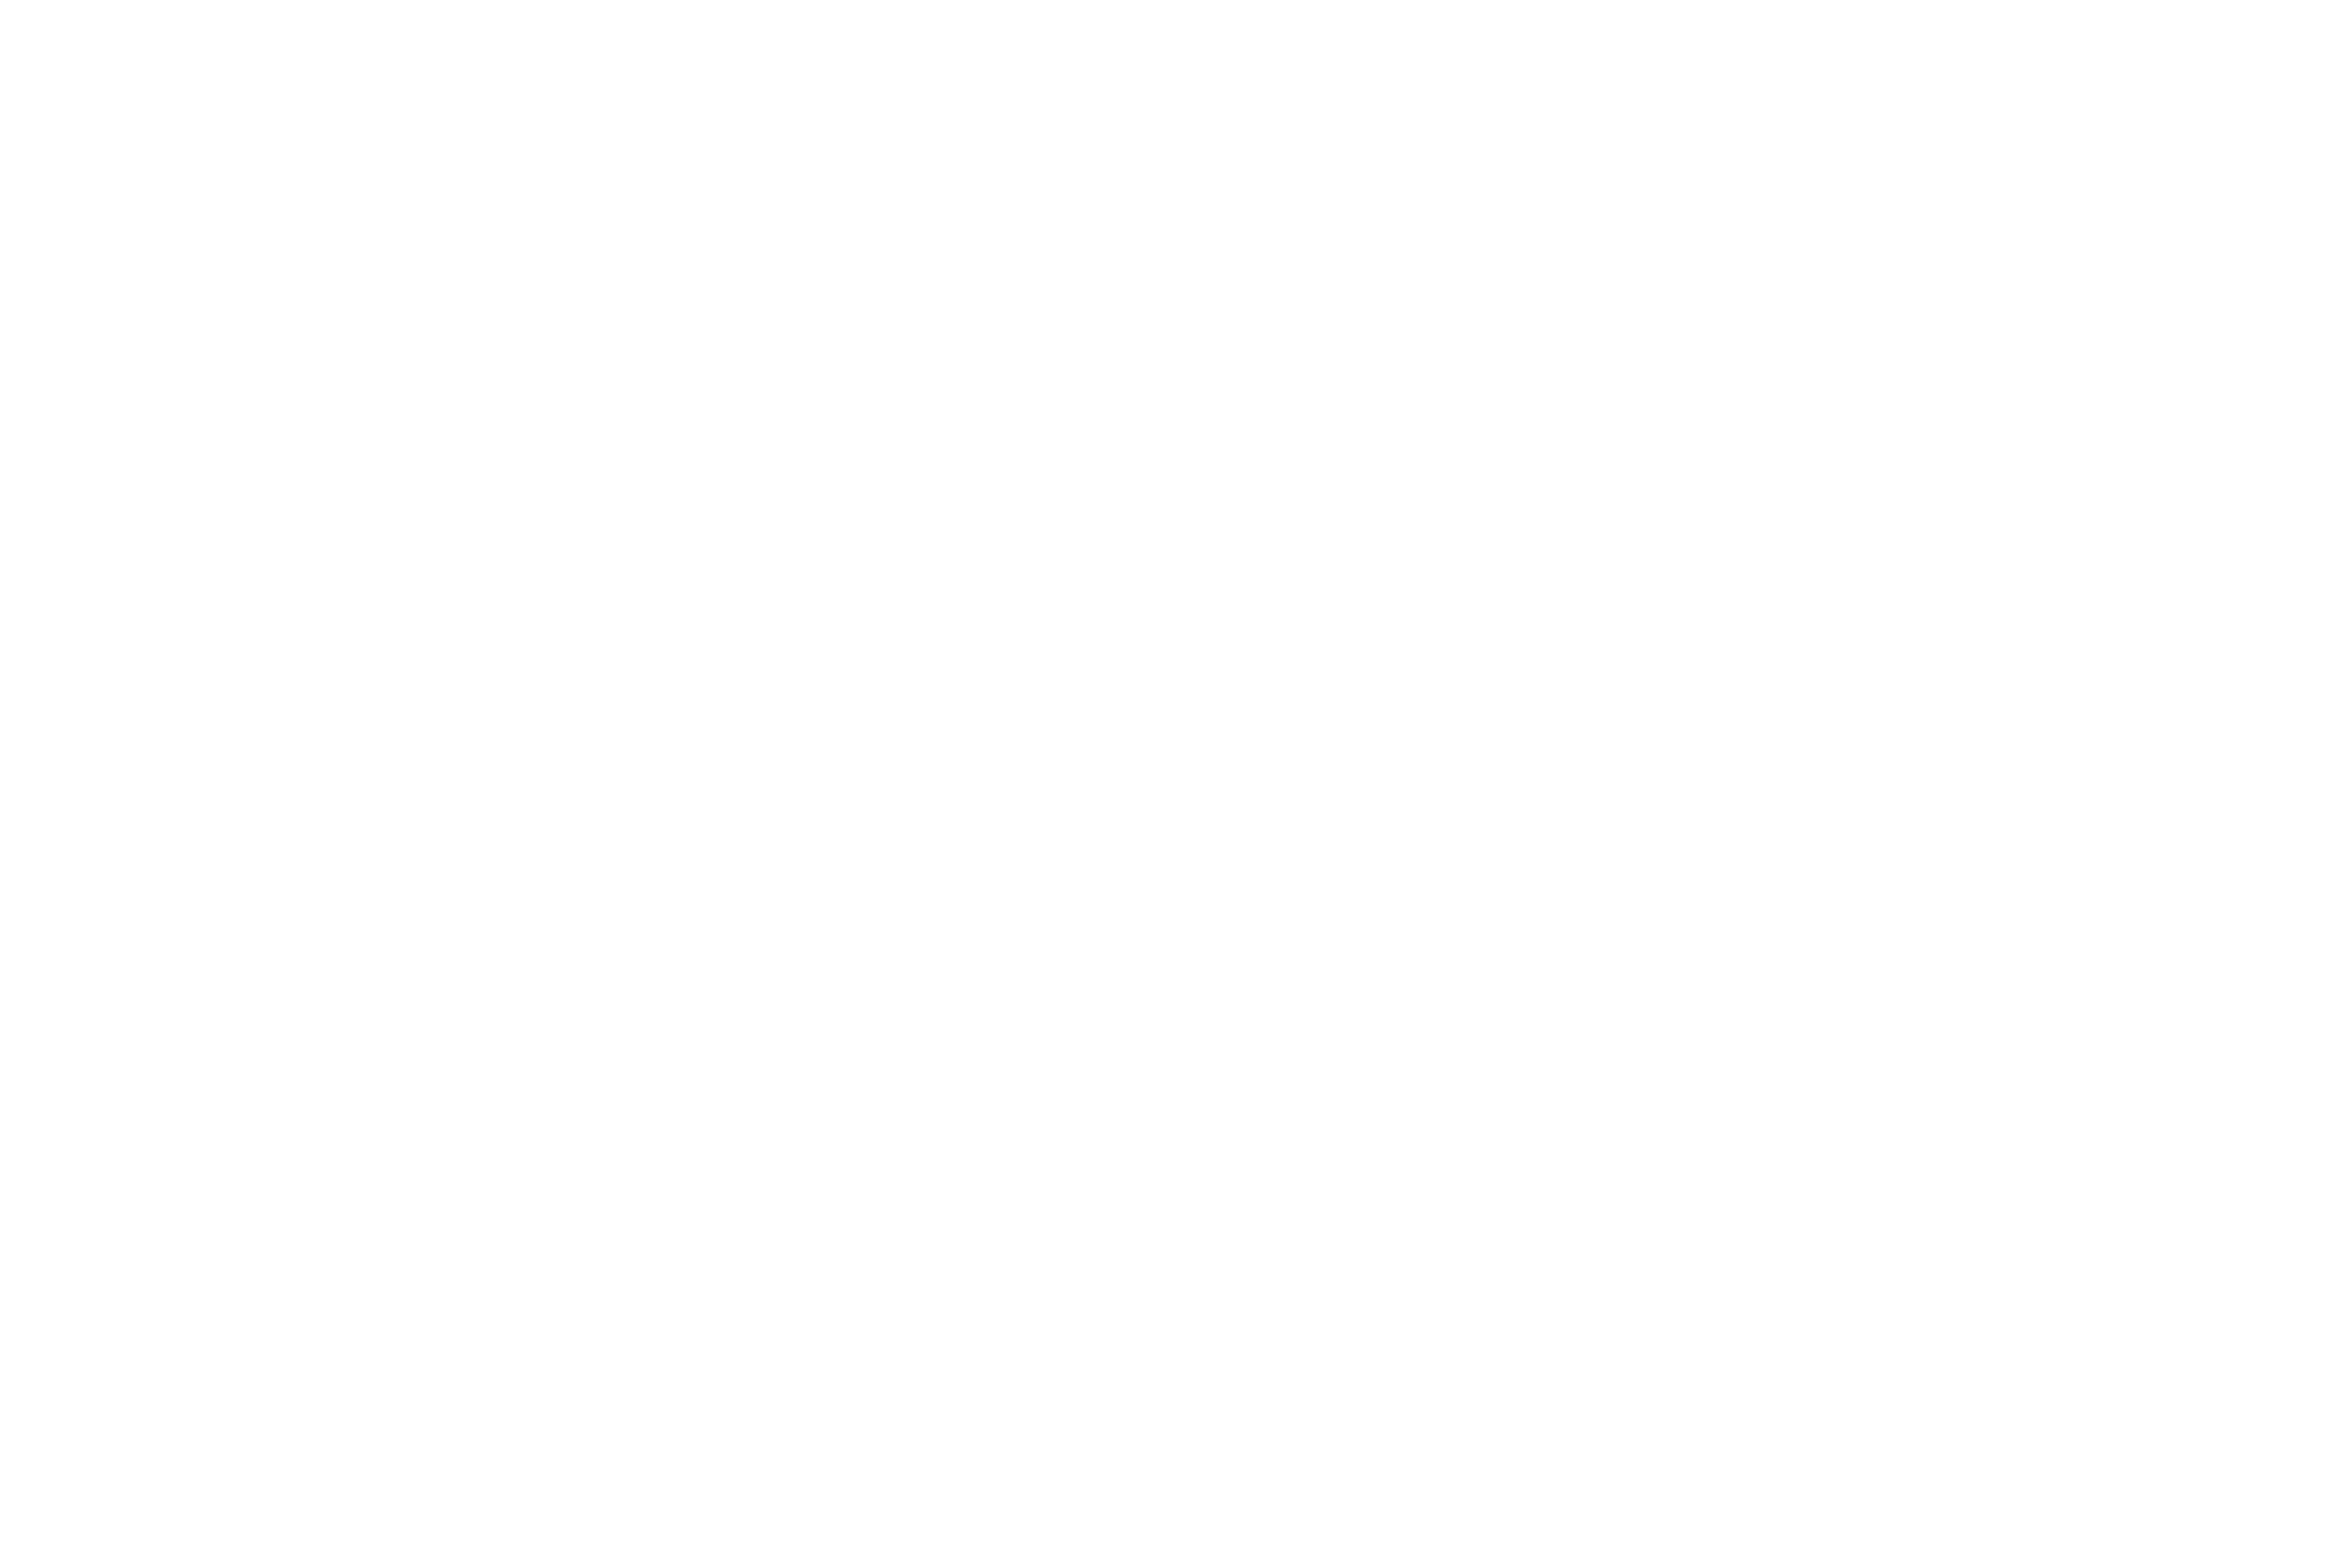

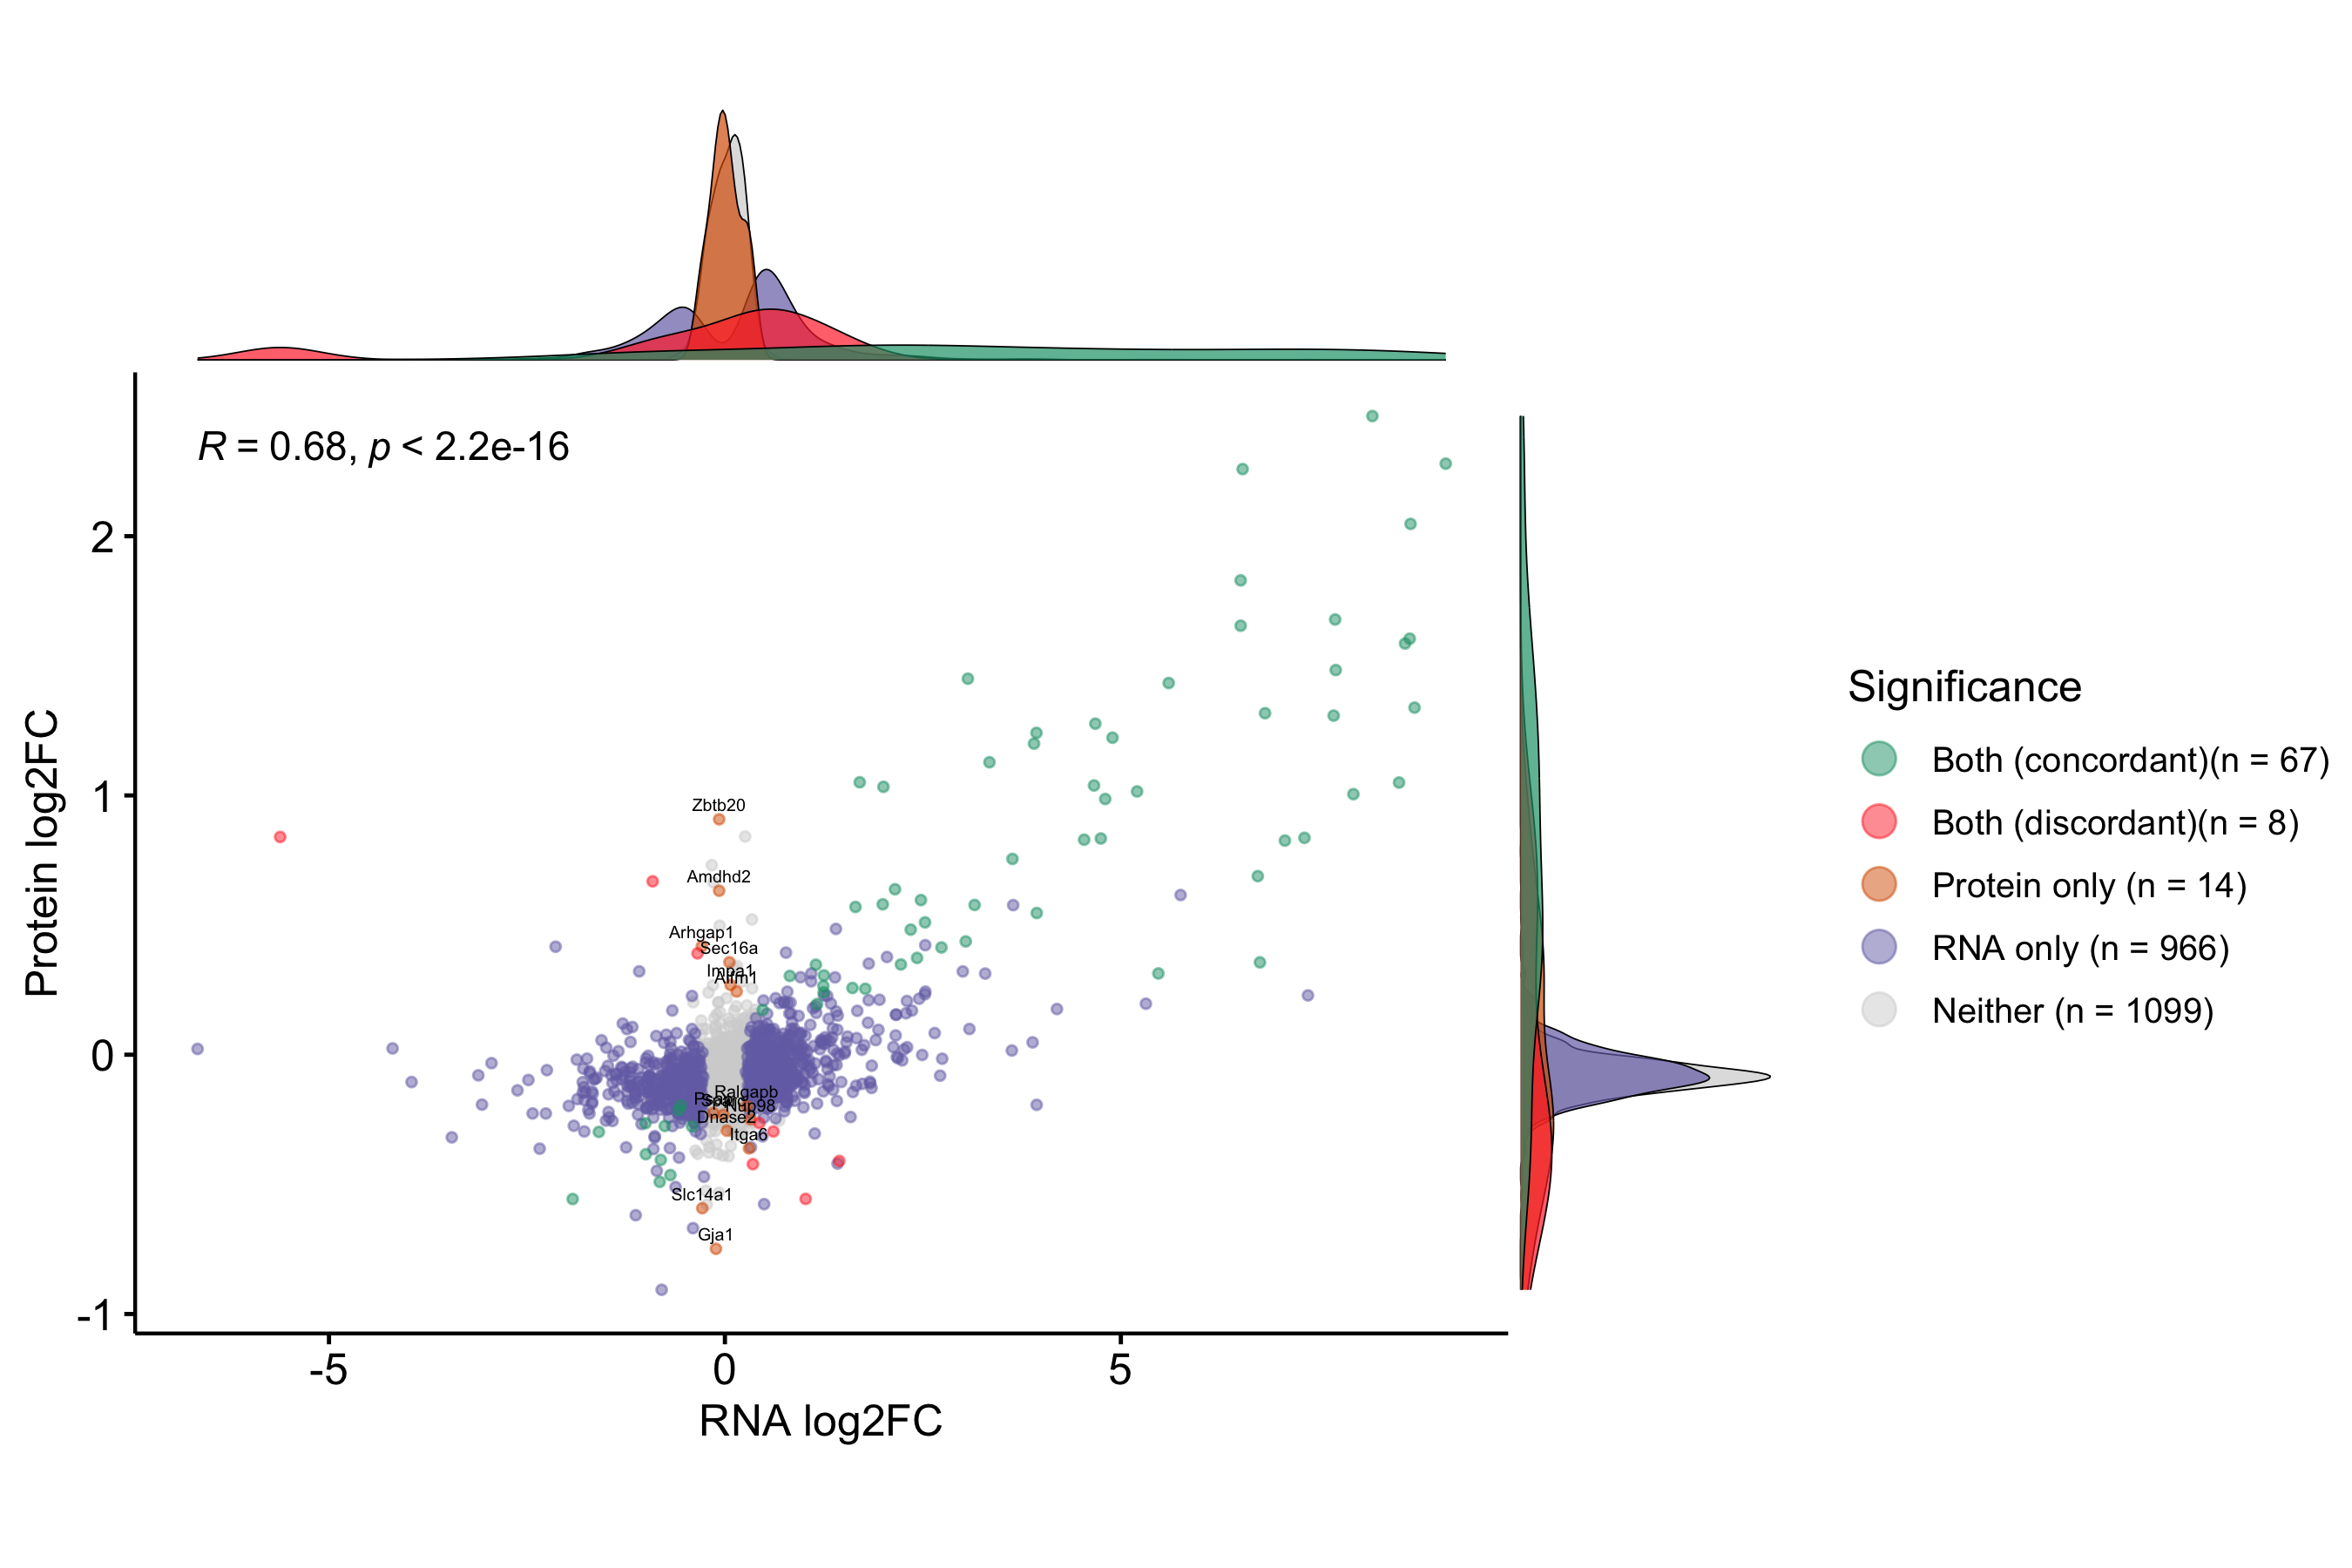

In [80]:
%%R -w 9 -h 6 --units in -r 300
# plot log2FC scatterplot comparing protein and gene changes in TICI versus PBS samples, and highlight the protein only entries
plot <- ggscatterhist(
 merge.df %>% arrange(significance), x = "log2FoldChange", y = "log2FC",
    alpha = 0.5, color = "Significance", shape = 19,
   fill = "Significance", size = 1, palette = c("lightgray", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[1], rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[2], "#FF3333", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[3]), 
    xlab = "RNA log2FC", ylab = "Protein log2FC",
    ggtheme = theme_pubr() + theme(aspect.ratio = 0.7), 
    cor.coef = TRUE, cor.method = "pearson", print = FALSE,
    label = "select_label", repel = FALSE, font.label = c(5, "plain", "black"),
 margin.params = list(fill = "Significance", color = "black", size = 0.2), legend = "right"
) 

plot$sp <- plot$sp + guides(color = guide_legend(reverse = TRUE, override.aes = list(size=4)), fill = FALSE)

plot

In [81]:
%%R -w 9 -h 6 --units in -r 300

ggexport(plot, filename = "relative_file_path/output_files/l2fc_plot_proteinonly.pdf")

R[write to console]: file saved to relative_file_path/output_files/l2fc_plot_proteinonly.pdf



In [82]:
%%R

merge.df <- merge.df %>% mutate(select_label = ifelse(Significance == "RNA only (n = 966)", gene_names, NA))

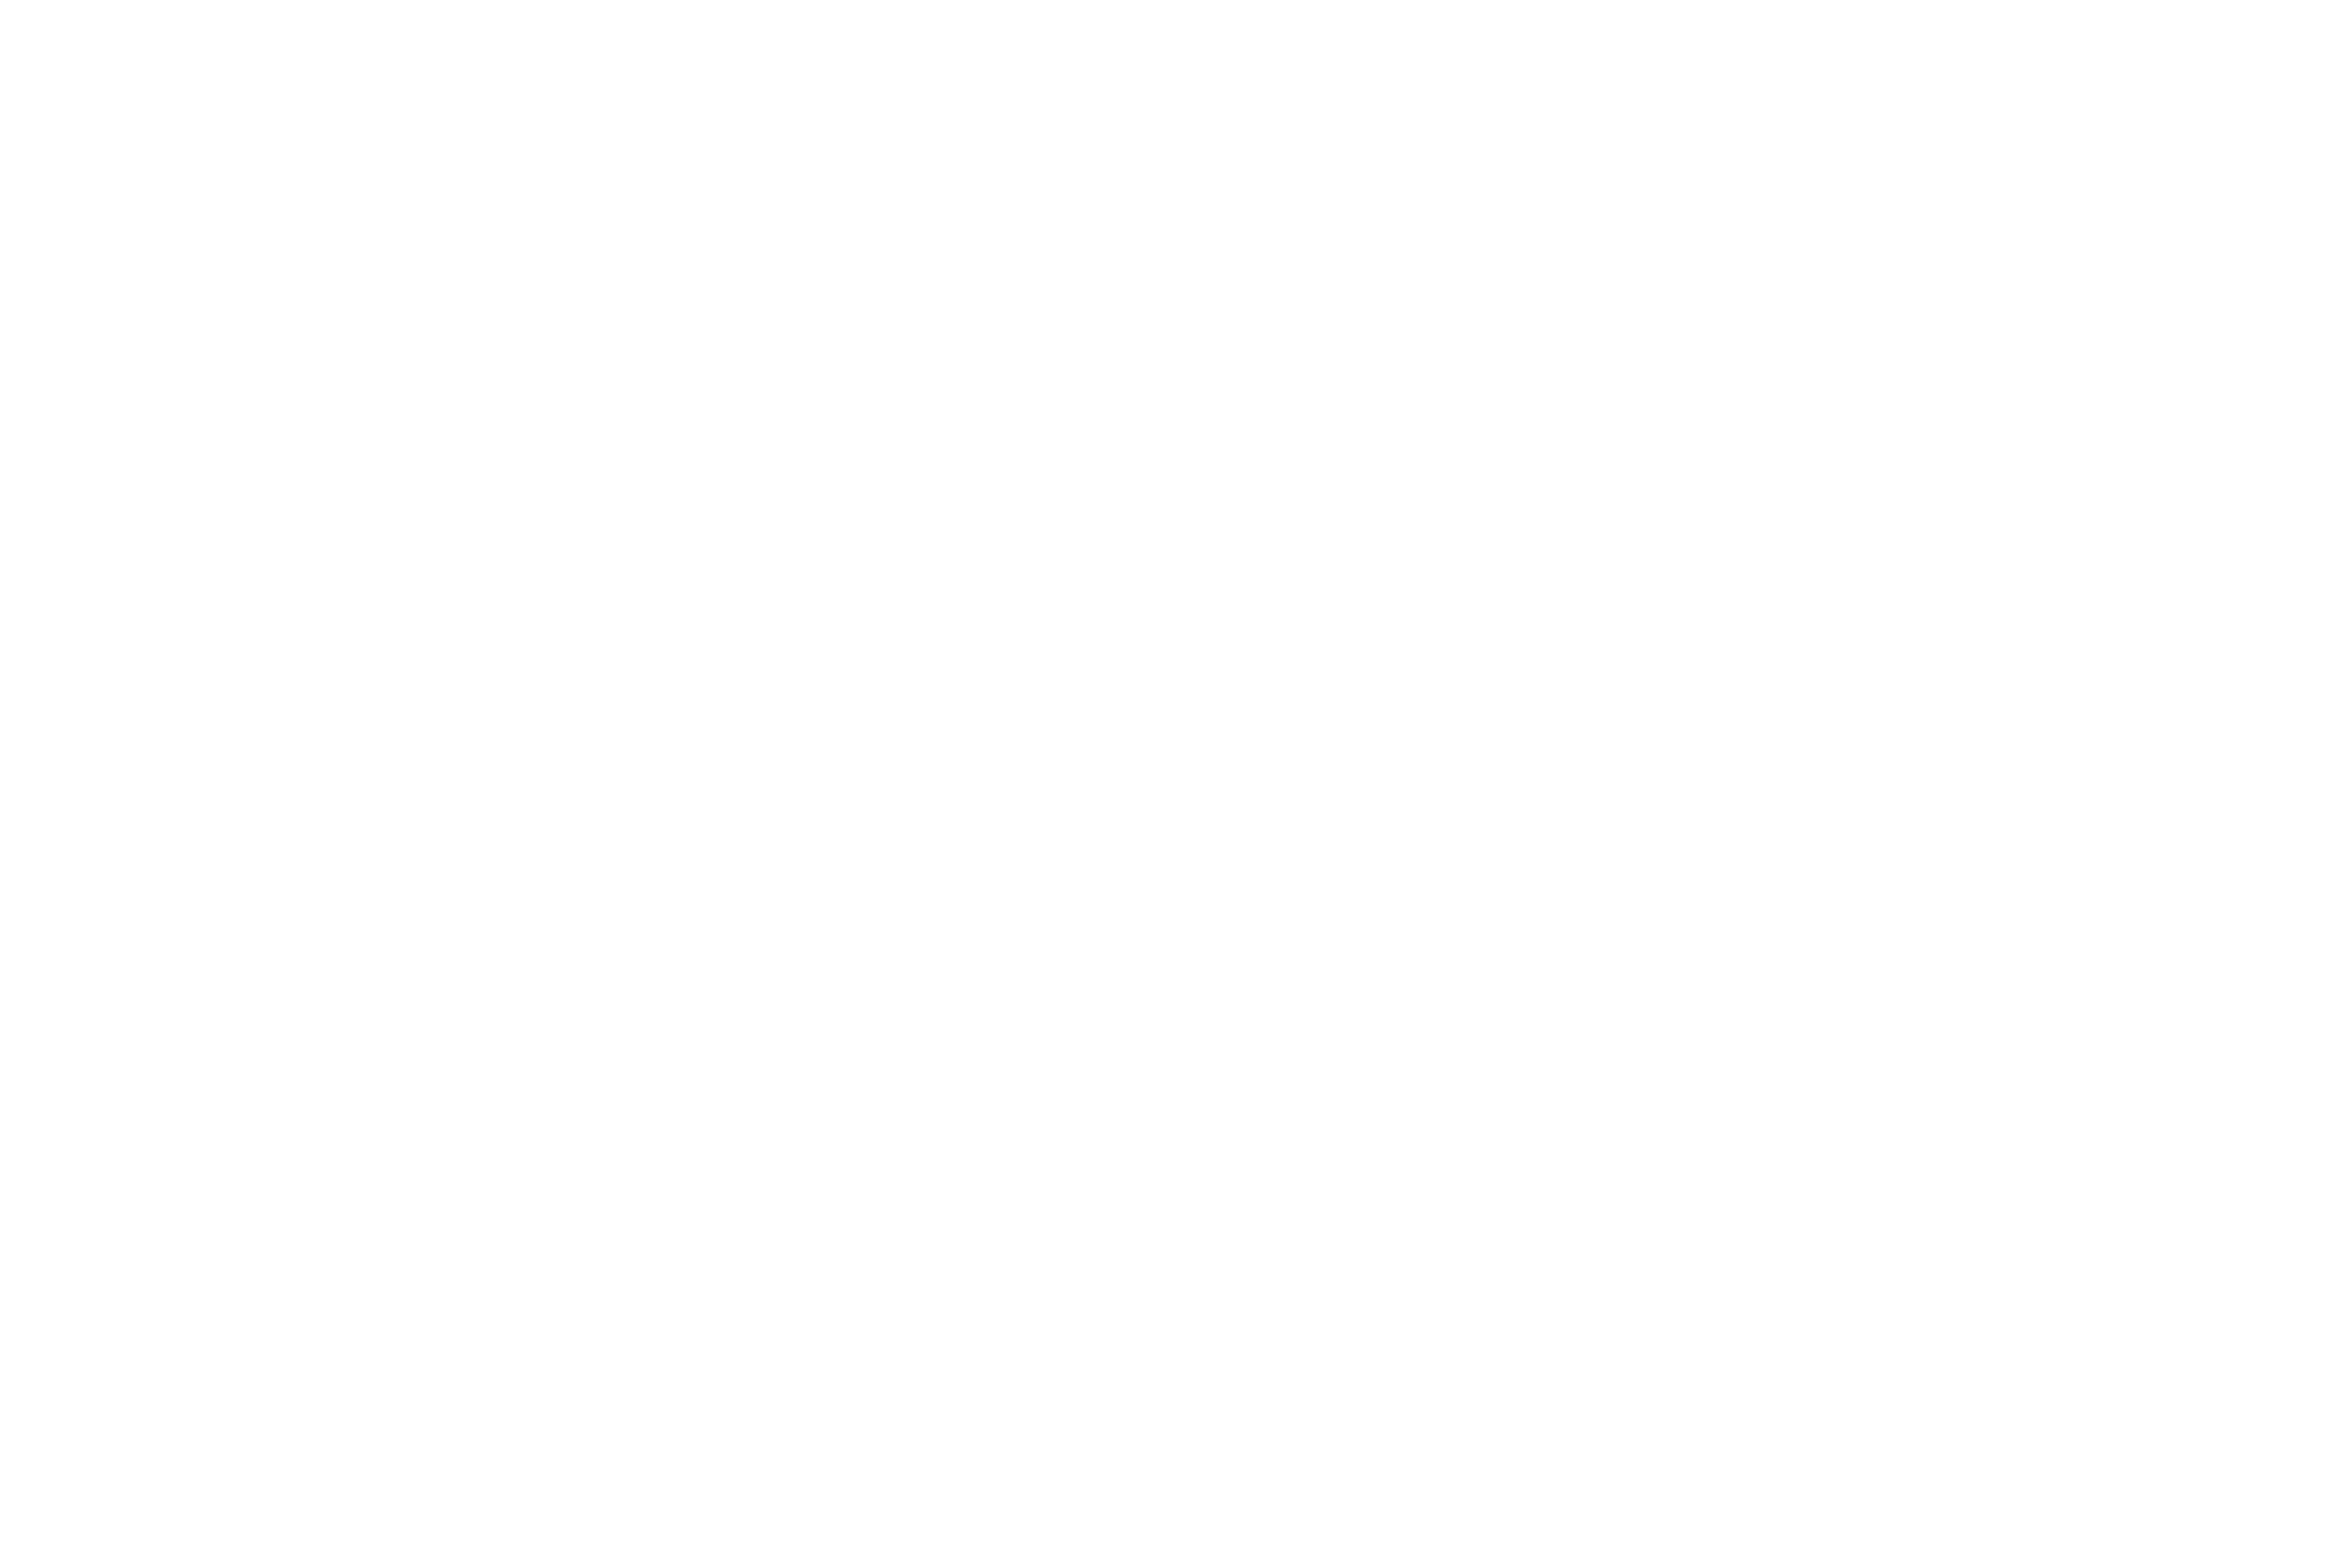

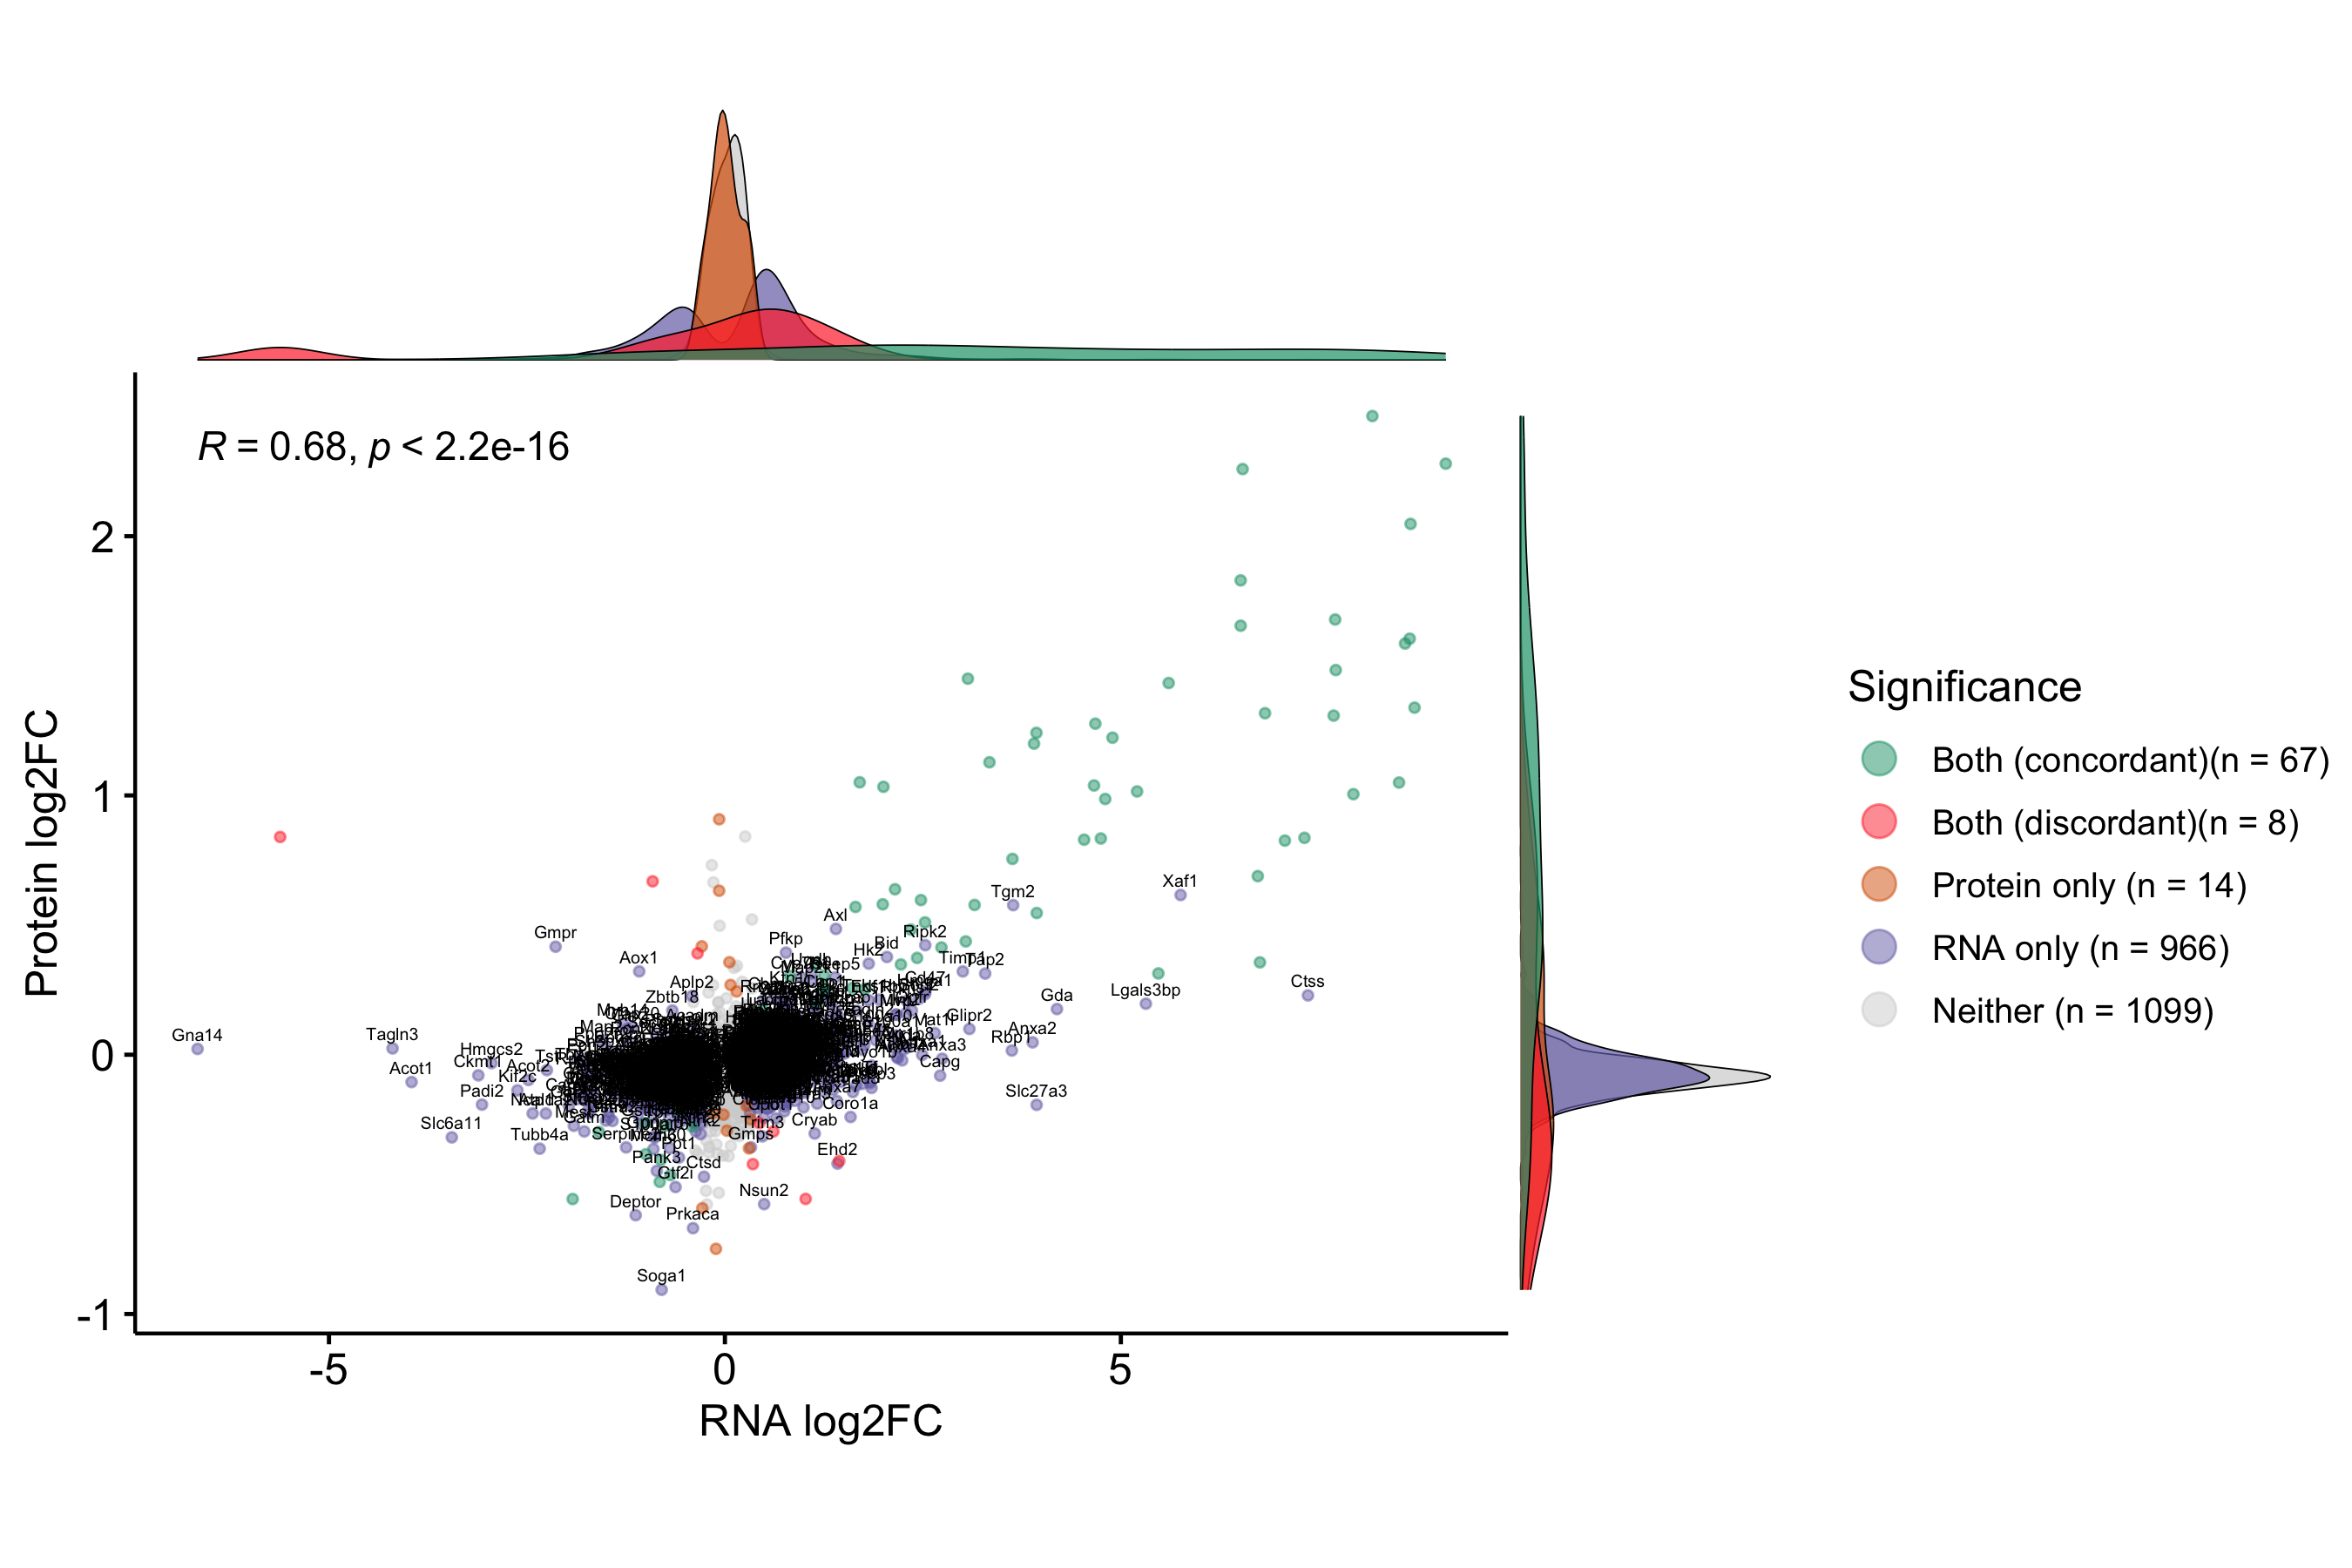

In [83]:
%%R -w 9 -h 6 --units in -r 300
# plot log2FC scatterplot comparing protein and gene changes in TICI versus PBS samples, and highlight the RNA only entries
plot <- ggscatterhist(
 merge.df %>% arrange(significance), x = "log2FoldChange", y = "log2FC",
    alpha = 0.5, color = "Significance", shape = 19,
   fill = "Significance", size = 1, palette = c("lightgray", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[1], rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[2], "#FF3333", rev(RColorBrewer::brewer.pal(n=3, name = "Dark2"))[3]), 
    xlab = "RNA log2FC", ylab = "Protein log2FC",
    ggtheme = theme_pubr() + theme(aspect.ratio = 0.7), 
    cor.coef = TRUE, cor.method = "pearson", print = FALSE,
    label = "select_label", repel = FALSE, font.label = c(5, "plain", "black"),
 margin.params = list(fill = "Significance", color = "black", size = 0.2), legend = "right"
) 

plot$sp <- plot$sp + guides(color = guide_legend(reverse = TRUE, override.aes = list(size=4)), fill = FALSE)

plot

In [84]:
%%R -w 9 -h 6 --units in -r 300

ggexport(plot, filename = "relative_file_path/output_files/l2fc_plot_rnaonly.pdf")

R[write to console]: file saved to relative_file_path/output_files/l2fc_plot_rnaonly.pdf

